In [1]:
import numpy as np
from collections import Counter
import pandas as pd
import json
import gzip
import networkx as nx
import netwulf as nw
from scipy import stats

# Introduction to data

The dataset consists of product reviews and metadata of products in the "Grocery and Gourmet Food" category on Amazon and was collected by researchers at UCSD.

The original reviews dataset has 142.8 million reviews spanning from May 1996 - July 2014. However, we use only use a subset of the dataset where all users and items have at least 5 reviews in the "Grocery and Gourmet Food" category, called food 5-core. The food 5-core dataset is 108 MB and contains 151,254 reviews, with each review having 9 attributes:

- <code>reviewerID</code> - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- <code>asin </code> - ID of the product, e.g. 0000013714
- <code>reviewerName </code> - name of the reviewer
- <code>helpful </code> - helpfulness rating of the review, e.g. 2/3
- <code>reviewText </code> - text of the review
- <code>overall </code> - rating of the product
- <code>summary </code> - summary of the review
- <code>unixReviewTime </code> - time of the review (unix time)
- <code>reviewTime </code> - time of the review (raw)

The metadata dataset contains metadata for 171,761 products in the "Gorcery and Gourmet Food" category and is 182 MB. Each product has 9 attributes:

- <code>asin </code> - ID of the product, e.g. 0000031852
- <code>title </code> - name of the product
- <code>price </code> - price in US dollars (at time of crawl)
- <code>imUrl </code> - url of the product image
- <code>related </code> - related products (also bought, also viewed, bought together, buy after viewing)
- <code>salesRank </code> - sales rank information
- <code>brand </code> - brand name
- <code>categories </code> - list of categories the product belongs to

# Project Idea

Text part:
Concatenate all review texts for the same product and compute the sentiment happiness. Then we compare the happiness score with the average rating of the product. Then we want to compute the linear correlation with Pearson's test. 

We would also like to analyse the sentiment and ratings across different categories, with word clouds for some of the categories.

Network part:
We want to analyse the products and how they are related, with products as nodes and a link between them if they are related. Each product has a category, e.g. ``beverage``, ``baby food``, ``canned dry and packed foods`` etc, so we can visualise communities. Furthermore, we can experiment if the Louvain algorithm can find a equivalent partition of the network. 

Additionally, we want to make a network of users as nodes and products reviewed in common as vertices. Then, we want to compare this network with a randomly generate network with the same clustering coefficient. 

# Explore data

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

def parse2(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF2(path):
    i = 0
    df = {}
    for d in parse2(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [3]:
review_df = getDF('data/reviews_Grocery_and_Gourmet_Food_5.json.gz')
review_df

reviewerID        asin  \
0       A1VEELTKS8NLZB  616719923X   
1       A14R9XMZVJ6INB  616719923X   
2       A27IQHDZFQFNGG  616719923X   
3       A31QY5TASILE89  616719923X   
4       A2LWK003FFMCI5  616719923X   
...                ...         ...   
151249  A2L6QS8SVHT9RG  B00KCJRVO2   
151250   AFJFXN42RZ3G2  B00KCJRVO2   
151251   ASEBX8TBYWQWA  B00KCJRVO2   
151252   ANKQGTXHREOI5  B00KCJRVO2   
151253  A2CF66KIQ3RKX3  B00KCJRVO2   

                                            reviewerName helpful  \
0                                        Amazon Customer  [0, 0]   
1                                                amf0001  [0, 1]   
2                                                Caitlin  [3, 4]   
3                                           DebraDownSth  [0, 0]   
4                                               Diana X.  [1, 2]   
...                                                  ...     ...   
151249              randomartco "period film aficionado"  [0, 0]   
151250                               R. DelParto "Rose2"  [0, 0]   
151251  Steven I. Ramm "Steve Ramm &#34;Anything Phon...  [1, 1]   
151252                                     Titanium Lili  [0, 1]   
151253                                      Vivian Deliz  [0, 0]   

                                               reviewText  overall  \
0       Just another flavor of Kit Kat but the taste i...      4.0   
1       I bought this on impulse and it comes from Jap...      3.0   
2       Really good. Great gift for any fan of green t...      4.0   
3       I had never had it before, was curious to see ...      5.0   
4       I've been looking forward to trying these afte...      4.0   
...                                                   ...      ...   
151249  Delicious gluten-free oatmeal: we tried both t...      4.0   
151250  With the many selections of instant oatmeal ce...      4.0   
151251  While I usually review CDs and DVDs, as well a...      5.0   
151252  My son and I enjoyed these oatmeal packets.  H...      4.0   
151253  I like to eat oatmeal i the mornings. I usuall...      4.0   

                                                  summary  unixReviewTime  \
0                                              Good Taste      1370044800   
1       3.5 stars,  sadly not as wonderful as I had hoped      1400457600   
2                                                    Yum!      1381190400   
3                                  Unexpected flavor meld      1369008000   
4       Not a very strong tea flavor, but still yummy ...      1369526400   
...                                                   ...             ...   
151249       Delicious gluten-free oatmeal 'quick' packs!      1405123200   
151250                             Convenient and Instant      1404604800   
151251  Compares favorably in taste and texture with o...      1404172800   
151252                                       Pretty good!      1404432000   
151253               I like to eat oatmeal i the mornings      1405036800   

         reviewTime  
0        06 1, 2013  
1       05 19, 2014  
2        10 8, 2013  
3       05 20, 2013  
4       05 26, 2013  
...             ...  
151249  07 12, 2014  
151250   07 6, 2014  
151251   07 1, 2014  
151252   07 4, 2014  
151253  07 11, 2014  

[151254 rows x 9 columns]

In [4]:
review_df['overall'][review_df['asin'] == '616719923X'].mean()

4.0625

In [5]:
product_df = getDF2('data/meta_Grocery_and_Gourmet_Food.json.gz')
product_df

asin                                        description  \
0       0657745316  This is real vanilla extract made with only 3 ...   
1       0700026444  Silverpot Tea, Pure Darjeeling, is an exquisit...   
2       1403796890  Must have for any WWE Fan\n \n \n \nFeaturing ...   
3       141278509X  Infused with Vitamins and Electrolytes Good So...   
4       1453060375  MiO Energy is your portable energy source givi...   
...            ...                                                ...   
171755  B00LDXFI6Y  Nescafe Cafe Viet is extracted from the aromat...   
171756  B00LMMLRG6  Moon Cheese Snacks Moon Cheese High in protein...   
171757  B00LOXAZ1Q  Sour Punch candy is the brand of mouth waterin...   
171758  B00LOZ7F0S  Our Vanilla Extract made from\nPremium, Organi...   
171759  B00LQWKDBM                                                NaN   

                                                    title  \
0                 100 Percent All Natural Vanilla Extract   
1                         Pure Darjeeling Tea: Loose Leaf   
2       WWE Kids Todler Velvet Slippers featuring John...   
3       Archer Farms Strawberry Dragonfruit Drink Mix ...   
4       Mio Energy Liquid Water Enhancer Black Cherry ...   
...                                                   ...   
171755  Nescafe Cafe Viet Vietnamese Sweetened Instant...   
171756      Moon Cheese, 2 Oz. Pack of Three (Assortment)   
171757  Sour Punch Blue Raspberry Bite, 5 Ounce Bag --...   
171758                            Organic Mexican Vanilla   
171759                  Mrs. Grass Onion Soup and Dip Mix   

                                                    imUrl  \
0       http://ecx.images-amazon.com/images/I/41gFi5h0...   
1       http://ecx.images-amazon.com/images/I/51hs8sox...   
2       http://ecx.images-amazon.com/images/I/518SEST5...   
3       http://ecx.images-amazon.com/images/I/51CFQIis...   
4       http://ecx.images-amazon.com/images/I/51EUsMcn...   
...                                                   ...   
171755  http://ecx.images-amazon.com/images/I/51qAGS7j...   
171756  http://ecx.images-amazon.com/images/I/419FO438...   
171757  http://ecx.images-amazon.com/images/I/31Cj3cHD...   
171758  http://ecx.images-amazon.com/images/I/11iORwy7...   
171759  http://ecx.images-amazon.com/images/I/31aDrMe4...   

                                                  related  \
0                         {'also_viewed': ['B001GE8N4Y']}   
1                                                     NaN   
2                                                     NaN   
3                         {'also_viewed': ['B0051IETTY']}   
4       {'also_viewed': ['B006MSEOJ2', 'B005VOOQLO', '...   
...                                                   ...   
171755                    {'also_viewed': ['B000DN8EZW']}   
171756                    {'also_viewed': ['B000UPFWW6']}   
171757                                                NaN   
171758                                                NaN   
171759      {'also_viewed': ['B00LAOSVPG', 'B001CAT22O']}   

                                 salesRank                  categories  price  \
0       {'Grocery & Gourmet Food': 374004}  [[Grocery & Gourmet Food]]    NaN   
1       {'Grocery & Gourmet Food': 620307}  [[Grocery & Gourmet Food]]    NaN   
2                                      NaN  [[Grocery & Gourmet Food]]   3.99   
3       {'Grocery & Gourmet Food': 620322}  [[Grocery & Gourmet Food]]    NaN   
4       {'Grocery & Gourmet Food': 268754}  [[Grocery & Gourmet Food]]  11.99   
...                                    ...                         ...    ...   
171755                                 NaN  [[Grocery & Gourmet Food]]  17.99   
171756   {'Grocery & Gourmet Food': 54090}  [[Grocery & Gourmet Food]]  16.95   
171757  {'Grocery & Gourmet Food': 133517}  [[Grocery & Gourmet Food]]  16.55   
171758                                 NaN  [[Grocery & Gourmet Food]]    NaN   
171759                                 NaN  [[G

In [6]:
np.unique(product_df['categories'])[0]

[['CDs & Vinyl', 'Blues', 'Piano Blues'],
 ['CDs & Vinyl', 'Pop', 'Oldies'],
 ['CDs & Vinyl', 'Pop', 'Singer-Songwriters'],
 ['CDs & Vinyl', 'R&B', 'Classic R&B'],
 ['CDs & Vinyl', 'Rock', 'Oldies & Retro'],
 ['Grocery & Gourmet Food', 'Beverages']]

In [7]:
for i in range(len(product_df)):
    if product_df['categories'].iloc[i] == [['CDs & Vinyl', 'Blues', 'Piano Blues'],
 ['CDs & Vinyl', 'Pop', 'Oldies'],
 ['CDs & Vinyl', 'Pop', 'Singer-Songwriters'],
 ['CDs & Vinyl', 'R&B', 'Classic R&B'],
 ['CDs & Vinyl', 'Rock', 'Oldies & Retro'],
 ['Grocery & Gourmet Food', 'Beverages']]:
        print(i)
        break

61


In [8]:
product_df.iloc[61]

asin                                                  B00005NTR2
description    Big and beautiful sluts with large round asses...
title                                          Whole Lotta Lovin
imUrl          http://ecx.images-amazon.com/images/I/21SV0SQE...
related        {'also_viewed': ['B00IZTKIDM', 'B001B8NP9I', '...
salesRank                                      {'Music': 776805}
categories     [[CDs & Vinyl, Blues, Piano Blues], [CDs & Vin...
price                                                       8.72
brand                                                        NaN
Name: 61, dtype: object

In [9]:
for i in range(len(product_df)):
    if product_df['categories'].iloc[i] == [['Grocery & Gourmet Food', 'Beverages', 'Powdered Drink Mixes', 'Soft Drink Mixes'], ['Clothing, Shoes & Jewelry', 'Women', 'Handbags & Wallets']]:
        print(i)
        break


144739


In [10]:
product_df.iloc[144739]

asin                                                  B00BFQ1VEW
description                                                  NaN
title            Anne Klein Tropical Punch Tote,Natural,One Size
imUrl          http://ecx.images-amazon.com/images/I/51PB8qMm...
related        {'also_bought': ['B00BML9P5M', 'B00C96U4TK'], ...
salesRank                                   {'Clothing': 423371}
categories     [[Grocery & Gourmet Food, Beverages, Powdered ...
price                                                        NaN
brand                                                        NaN
Name: 144739, dtype: object

Verify that there indeed are at least 5 reviews for each user and product.

In [11]:
asin_counts = Counter(list(review_df['asin']))
reviewerID_counts = Counter(list(review_df['reviewerID']))
# print(asin_counts)
# print(reviewerID_counts)

# Preprocess

In [ ]:
nan_prices = 0
for price in product_df['price']:
    if np.isnan(price):
        nan_prices+=1

print("Percentage nan prices:", np.round(nan_prices/len(product_df),3))
print("Amount of prices total:", len(product_df))


In [ ]:
asin_review_list = np.unique(list(review_df['asin']))

count = 0
related_products = []
rel = {}
idx = []
# loop over all products in product_df
for i in range(len(product_df)):
    asin = product_df.iloc[i]['asin']
    
    # if product is in the review df, find its related products.
    if asin in asin_review_list:
        related = product_df.iloc[i]['related']
        
        # check that the product has related items
        if str(related) != "nan":
            related_prod = []
            
            # loop over every key: also viewed, also bought, etc.
            for key in related.keys():
                # check that every related product is also in review_df
                for prod in related[key]:
                    if prod in asin_review_list:
                        related_prod.append(prod)
            rel[i] = related_prod
            related_products.append(related_prod)
        else:
            idx.append(i)
    
    else:
        idx.append(i)

In [ ]:
# remove indices in original df
product_df2 = product_df.drop(idx)
product_df2.to_csv("data/product_df2.csv", index=False)
# make a new column 
product_df3 = product_df2.assign(related_products = related_products)
# explode column related_products
product_df3 = product_df3.explode('related_products')
product_df3.to_csv("data/product_df3.csv", index=False)

Verify that the correct indices have been dropped :)

In [ ]:
a = set(list(product_df2.index))
b = set(list(rel.keys()))

In [ ]:
a - a.intersection(b)

# Reviewer network

In [12]:
review_df

reviewerID        asin  \
0       A1VEELTKS8NLZB  616719923X   
1       A14R9XMZVJ6INB  616719923X   
2       A27IQHDZFQFNGG  616719923X   
3       A31QY5TASILE89  616719923X   
4       A2LWK003FFMCI5  616719923X   
...                ...         ...   
151249  A2L6QS8SVHT9RG  B00KCJRVO2   
151250   AFJFXN42RZ3G2  B00KCJRVO2   
151251   ASEBX8TBYWQWA  B00KCJRVO2   
151252   ANKQGTXHREOI5  B00KCJRVO2   
151253  A2CF66KIQ3RKX3  B00KCJRVO2   

                                            reviewerName helpful  \
0                                        Amazon Customer  [0, 0]   
1                                                amf0001  [0, 1]   
2                                                Caitlin  [3, 4]   
3                                           DebraDownSth  [0, 0]   
4                                               Diana X.  [1, 2]   
...                                                  ...     ...   
151249              randomartco "period film aficionado"  [0, 0]   
151250                               R. DelParto "Rose2"  [0, 0]   
151251  Steven I. Ramm "Steve Ramm &#34;Anything Phon...  [1, 1]   
151252                                     Titanium Lili  [0, 1]   
151253                                      Vivian Deliz  [0, 0]   

                                               reviewText  overall  \
0       Just another flavor of Kit Kat but the taste i...      4.0   
1       I bought this on impulse and it comes from Jap...      3.0   
2       Really good. Great gift for any fan of green t...      4.0   
3       I had never had it before, was curious to see ...      5.0   
4       I've been looking forward to trying these afte...      4.0   
...                                                   ...      ...   
151249  Delicious gluten-free oatmeal: we tried both t...      4.0   
151250  With the many selections of instant oatmeal ce...      4.0   
151251  While I usually review CDs and DVDs, as well a...      5.0   
151252  My son and I enjoyed these oatmeal packets.  H...      4.0   
151253  I like to eat oatmeal i the mornings. I usuall...      4.0   

                                                  summary  unixReviewTime  \
0                                              Good Taste      1370044800   
1       3.5 stars,  sadly not as wonderful as I had hoped      1400457600   
2                                                    Yum!      1381190400   
3                                  Unexpected flavor meld      1369008000   
4       Not a very strong tea flavor, but still yummy ...      1369526400   
...                                                   ...             ...   
151249       Delicious gluten-free oatmeal 'quick' packs!      1405123200   
151250                             Convenient and Instant      1404604800   
151251  Compares favorably in taste and texture with o...      1404172800   
151252                                       Pretty good!      1404432000   
151253               I like to eat oatmeal i the mornings      1405036800   

         reviewTime  
0        06 1, 2013  
1       05 19, 2014  
2        10 8, 2013  
3       05 20, 2013  
4       05 26, 2013  
...             ...  
151249  07 12, 2014  
151250   07 6, 2014  
151251   07 1, 2014  
151252   07 4, 2014  
151253  07 11, 2014  

[151254 rows x 9 columns]

In [13]:
nodes = np.unique(list(review_df['reviewerID']))


In [14]:
import random

# 500 random products
review_dict = {}
random.seed(19)
products = np.unique(list(review_df['asin']))
products = random.sample(list(products), 500)

for product in products:
    reviewers = list(review_df[review_df['asin'] == product]['reviewerID'])
    review_dict[product] = reviewers

In [15]:
# first 500 products
# review_dict = {}
# products = np.unique(list(review_df['asin']))[:500]

# for product in products:
#     reviewers = list(review_df[review_df['asin'] == product]['reviewerID'])
#     review_dict[product] = reviewers

In [16]:
len(review_dict)

500

In [17]:
edges = []

for key in review_dict.keys():
    reviewers = review_dict[key]
    for i in range(len(reviewers)):
        node1 = reviewers[i]
        for j in range(i+1, len(reviewers)):
            node2 = reviewers[j]
            edges.append(tuple([node1, node2]))
                
#     break
edges

[('A3RA3PWBYQMLT6', 'A22A3YXFDLPMFL'),
 ('A3RA3PWBYQMLT6', 'ADPSJZPG8F3D'),
 ('A3RA3PWBYQMLT6', 'A1KKE6VX8VPWZK'),
 ('A3RA3PWBYQMLT6', 'A2N4SU1O376NGJ'),
 ('A3RA3PWBYQMLT6', 'ABCFSR5TFF22K'),
 ('A3RA3PWBYQMLT6', 'AZV26LP92E6WU'),
 ('A3RA3PWBYQMLT6', 'AL5GX3Y4LRHK1'),
 ('A3RA3PWBYQMLT6', 'A5I3B25LKW8GK'),
 ('A3RA3PWBYQMLT6', 'A1698RISUBREP'),
 ('A3RA3PWBYQMLT6', 'A3KNGMX2RVQG91'),
 ('A3RA3PWBYQMLT6', 'A2S73Z7ZR6HAMX'),
 ('A3RA3PWBYQMLT6', 'A34RGHJI7CGF0U'),
 ('A22A3YXFDLPMFL', 'ADPSJZPG8F3D'),
 ('A22A3YXFDLPMFL', 'A1KKE6VX8VPWZK'),
 ('A22A3YXFDLPMFL', 'A2N4SU1O376NGJ'),
 ('A22A3YXFDLPMFL', 'ABCFSR5TFF22K'),
 ('A22A3YXFDLPMFL', 'AZV26LP92E6WU'),
 ('A22A3YXFDLPMFL', 'AL5GX3Y4LRHK1'),
 ('A22A3YXFDLPMFL', 'A5I3B25LKW8GK'),
 ('A22A3YXFDLPMFL', 'A1698RISUBREP'),
 ('A22A3YXFDLPMFL', 'A3KNGMX2RVQG91'),
 ('A22A3YXFDLPMFL', 'A2S73Z7ZR6HAMX'),
 ('A22A3YXFDLPMFL', 'A34RGHJI7CGF0U'),
 ('ADPSJZPG8F3D', 'A1KKE6VX8VPWZK'),
 ('ADPSJZPG8F3D', 'A2N4SU1O376NGJ'),
 ('ADPSJZPG8F3D', 'ABCFSR5TFF22K'),
 ('ADPS

In [18]:
from_ = [edge[0] for edge in edges]
to_ = [edge[1] for edge in edges]
df = pd.DataFrame()
df['from'] = from_
df['to'] = to_
df2 = df.drop_duplicates()
df2

from              to
0       A3RA3PWBYQMLT6  A22A3YXFDLPMFL
1       A3RA3PWBYQMLT6    ADPSJZPG8F3D
2       A3RA3PWBYQMLT6  A1KKE6VX8VPWZK
3       A3RA3PWBYQMLT6  A2N4SU1O376NGJ
4       A3RA3PWBYQMLT6   ABCFSR5TFF22K
...                ...             ...
234304   A94C4KEY3B5DV   A6YEAHCVOHKWM
234305   A94C4KEY3B5DV   AG6TX1ZJHLMO7
234306  A2T875QZZMQ70L   A6YEAHCVOHKWM
234307  A2T875QZZMQ70L   AG6TX1ZJHLMO7
234308   A6YEAHCVOHKWM   AG6TX1ZJHLMO7

[229770 rows x 2 columns]

In [19]:
a = df2.groupby(['from', 'to']).count()
links = list(a.index)
links

[('A1004703RC79J9', 'A11A75FIE3396D'),
 ('A1004703RC79J9', 'A120ECBQV6449S'),
 ('A1004703RC79J9', 'A1LLG2MPYVFAIK'),
 ('A1004703RC79J9', 'A1VJS5J9RWVQ5K'),
 ('A1004703RC79J9', 'A1YJMG0QJXZLD4'),
 ('A1004703RC79J9', 'A21K28EQ023UUU'),
 ('A1004703RC79J9', 'A2835FANQ9CSJY'),
 ('A1004703RC79J9', 'A28ETU4J2PG09N'),
 ('A1004703RC79J9', 'A29313797NGT9L'),
 ('A1004703RC79J9', 'A2HS0HUHVLT9NG'),
 ('A1004703RC79J9', 'A2OKOOSFLJHD5E'),
 ('A1004703RC79J9', 'A2UOHALGF2X77Q'),
 ('A1004703RC79J9', 'A32Q726D4KHNHH'),
 ('A1004703RC79J9', 'A32U9FBU6IN5RF'),
 ('A1004703RC79J9', 'A37NNC4NMVMR4S'),
 ('A1004703RC79J9', 'A3AUJXJ7LDX8B0'),
 ('A1004703RC79J9', 'A3FD9FWGETS6M7'),
 ('A1004703RC79J9', 'A3OEPPOUC7PCHO'),
 ('A1004703RC79J9', 'A52Y39SZ0HMRX'),
 ('A1004703RC79J9', 'AEV34C745C0FH'),
 ('A1004703RC79J9', 'AG4U11RFDY7LU'),
 ('A1004703RC79J9', 'AO09RWV40IX78'),
 ('A100DXY4SLAMPM', 'A13AAHUP1MY6Z1'),
 ('A100DXY4SLAMPM', 'A1YUWK0O71JG0W'),
 ('A100DXY4SLAMPM', 'A2FI9CP6R2K9OC'),
 ('A100DXY4SLAMPM', 'A2FYXJ39

In [20]:
# links = [('a','b'), 
#          ('b','a'), 
#          ('a','b'),
#          ('a','b'),
#          ('b','a'),
#          ('a','c'),
#          ('a','c'),
#          ('a','d')]

In [21]:
# Find duplicate edges. Since the graph is undirected the edge (a,b) is the same as (b,a)

edge_dict = {}
for (f,t) in links:
    add = True
    if (f,t) not in edge_dict.keys():
        edge_dict[(f,t)] = 0
        if (t,f) in edge_dict.keys():
            edge_dict.pop((f,t))
            edge_dict[(t,f)] += 1
            add = False
    if add:
        edge_dict[(f,t)] += 1
    

In [22]:
# import networkx as nx
G = nx.Graph()
# G.add_nodes_from(nodes)
G.add_nodes_from(list(np.unique(from_+to_)))

weighted_edges = [(f,t,w) for ((f,t),w) in zip(edge_dict.keys(), edge_dict.values())]
G.add_weighted_edges_from(weighted_edges)

print(G.number_of_nodes())
print(G.number_of_edges())

5773
229767


In [336]:
import netwulf as nw
stylized_network, config = nw.visualize(G, plot_in_cell_below=False)

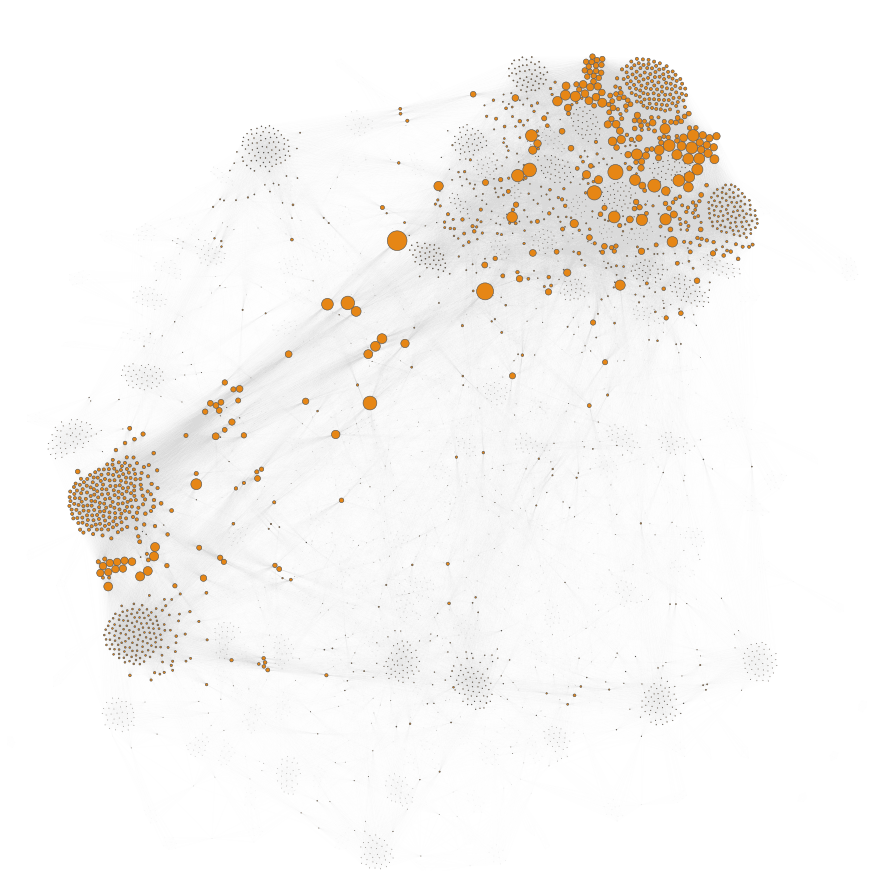

In [337]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

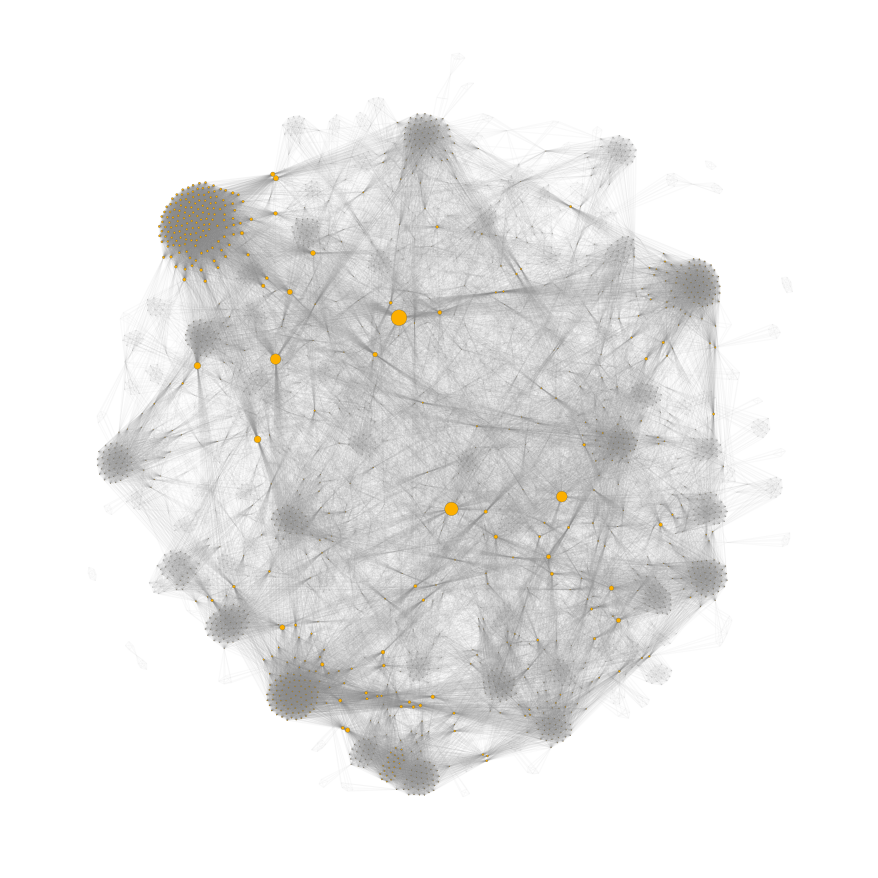

In [87]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

In [88]:
config

{'zoom': 0.6,
 'node_charge': -97.1917051981397,
 'node_gravity': 0.1570695578209938,
 'link_distance': 15,
 'link_distance_variation': 0.4,
 'node_collision': True,
 'wiggle_nodes': False,
 'freeze_nodes': False,
 'node_fill_color': '#fcaf00',
 'node_stroke_color': '#555555',
 'node_label_color': '#000000',
 'display_node_labels': False,
 'scale_node_size_by_strength': True,
 'node_size': 32.67115471378817,
 'node_stroke_width': 0.3679090479851124,
 'node_size_variation': 1.9602692828272903,
 'link_color': '#7c7c7c',
 'link_width': 2,
 'link_alpha': 0.03679090479851124,
 'link_width_variation': 0.5,
 'display_singleton_nodes': True,
 'min_link_weight_percentile': 0,
 'max_link_weight_percentile': 1}

# Let's look at some users

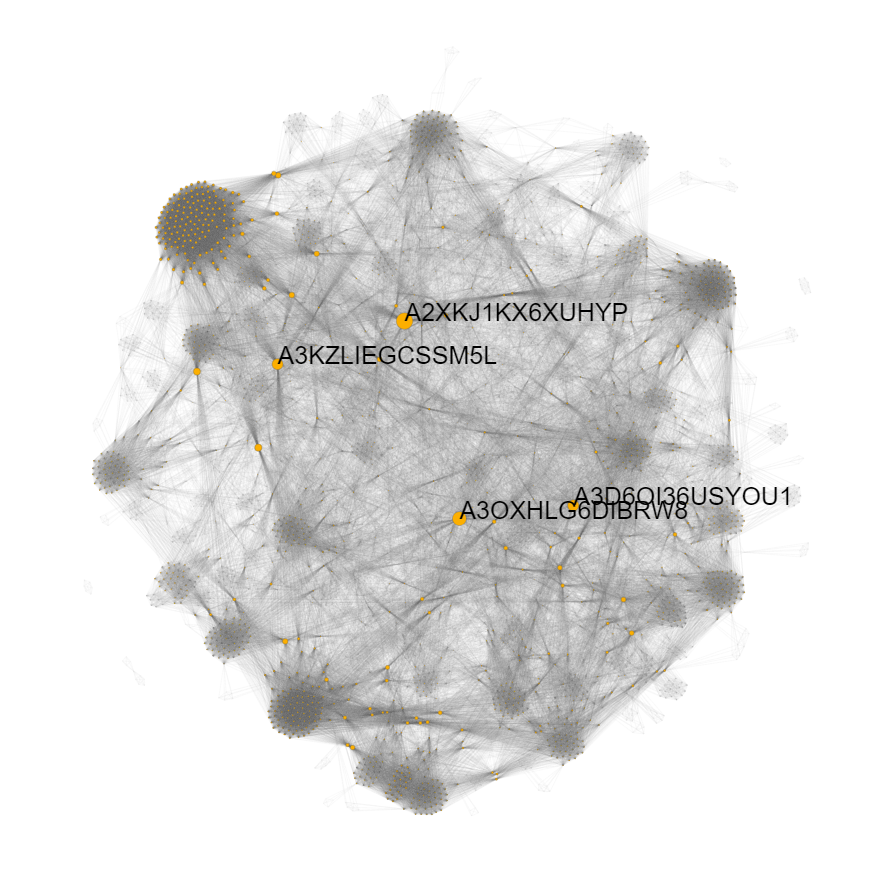

Culprits:
- A2XKJ1KX6XUHYP
- A3KZLIEGCSSM5L
- A3OXHLG6DIBRW8
- A3D6OI36USYOU1

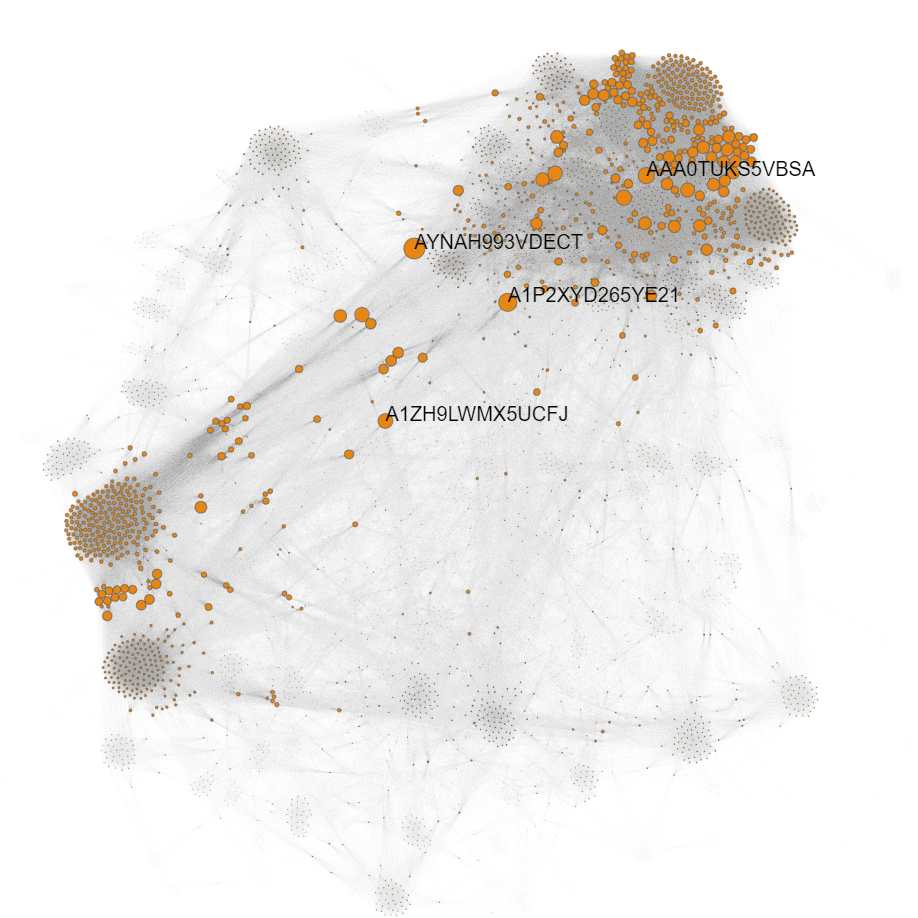

Culprits (with highest node degree):
- A1ZH9LWMX5UCFJ
- AYNAH993VDECT
- A1P2XYD265YE21
- AAA0TUKS5VBSA

In [23]:
idxs = []
for i in range(len(products)):
    idx = np.where(review_df['asin'] == products[i])
    idxs.extend(idx[0])

In [94]:
culprits_df = review_df.iloc[idxs]
# find the review for all culprits
# culprits = ['A2XKJ1KX6XUHYP', 'A3KZLIEGCSSM5L', 'A3OXHLG6DIBRW8', 'A3D6OI36USYOU1']
culprits = ['A1ZH9LWMX5UCFJ','AYNAH993VDECT', 'A1P2XYD265YE21', 'AAA0TUKS5VBSA']
for culprit in culprits:
    reviews = culprits_df[culprits_df['reviewerID'] == culprit]
    n = len(reviews)
    print("The reviewer name is:", reviews['reviewerName'].iloc[0])
    print("Number of reviews in subset:", n)
    print("Sample review text:", reviews['reviewText'].iloc[np.random.randint(n)])
    print("Node degree in network:", G.degree[culprit])

    # which products have they reviewed the most? :)
    
    
    print("\n")


The reviewer name is: K. Stuckey "kateling"
Number of reviews in subset: 10
Sample review text: These cookies are much closer to homemade than most of those break-and-bake cookies out there, with similar nutritional info. Very soft, with lots of plump raisins, great on the go!
Node degree in network: 610


The reviewer name is: bsg2004
Number of reviews in subset: 5
Sample review text: The Lipton Natural Energy, 40 Count comes in a fancier than usual Lipton packaging, so it may be used as a gift of sorts. Inside there are two sealed sets of 20 tea bags. The tea bags are not individually sealed. They are stored inside a tray which goes inside the outer golden wrapper. Both the wrappers and the outside box have a gold and yellow and sun color theme, which add to their fancier than usual look. On the practical front, the outer box has two little flaps on the front side that turn it into a self-locking package. On one of the sides of the outer box, there is a semi-coded &#34;best if used b

In [97]:
# let's look at the reviewers with the most reviews in our dataset. 
culprits_df.groupby('reviewerID').count().sort_values('asin', ascending=False).iloc[0:10]

asin  reviewerName  helpful  reviewText  overall  summary  \
reviewerID                                                                  
A2XKJ1KX6XUHYP    15            15       15          15       15       15   
A1X1CEGHTHMBL1    11            11       11          11       11       11   
A3OXHLG6DIBRW8    10            10       10          10       10       10   
A2MNB77YGJ3CN0    10            10       10          10       10       10   
A2YKWYC3WQJX5J    10            10       10          10       10       10   
A1ZH9LWMX5UCFJ    10            10       10          10       10       10   
A1UQBFCERIP7VJ    10            10       10          10       10       10   
A3NHUQ33CFH3VM     9             9        9           9        9        9   
A2MUGFV2TDQ47K     9             9        9           9        9        9   
A25C2M3QF9G7OQ     9             9        9           9        9        9   

                unixReviewTime  reviewTime  
reviewerID                                  
A2XKJ1KX6XUHYP              15          15  
A1X1CEGHTHMBL1              11          11  
A3OXHLG6DIBRW8              10          10  
A2MNB77YGJ3CN0              10          10  
A2YKWYC3WQJX5J              10          10  
A1ZH9LWMX5UCFJ              10          10  
A1UQBFCERIP7VJ              10          10  
A3NHUQ33CFH3VM               9           9  
A2MUGFV2TDQ47K               9           9  
A25C2M3QF9G7OQ               9           9

It is worth noting that among the identified users with the highest node degree, only one of them (K. Stuckey "kateling") is among the users with the top 10 most reviews. However, keep in mind that the network has an edge between two nodes if they have reviewed the same product. This means if a product has been reviewed by many people, then the users who have reviewed that product will have many edges. 

In [116]:
culprits2 = ['A1ZH9LWMX5UCFJ','AYNAH993VDECT', 'A1P2XYD265YE21', 'AAA0TUKS5VBSA'] + ['A2XKJ1KX6XUHYP']
most_reviewed_products_count = most_reviewed_products = culprits_df.groupby('asin').count().sort_values('reviewerID', ascending=False)

for culprit in culprits2:
    reviewed_products = list(culprits_df[culprits_df['reviewerID'] == culprit]['asin'])
    reviews = culprits_df[culprits_df['reviewerID'] == culprit]
    print("The reviewer name is:", reviews['reviewerName'].iloc[0])
    print("Reviewer:", culprit)
    sum_ = 0
    for reviewed_product in reviewed_products:
        n = int(most_reviewed_products.loc[most_reviewed_products.index == reviewed_product]['reviewerID'])
        print("The product {} has {} reviews".format(reviewed_product, n))
        sum_ += n
    print("Total:", sum_)
    print('\n')

The reviewer name is: K. Stuckey "kateling"
Reviewer: A1ZH9LWMX5UCFJ
The product B00DILCU92 has 122 reviews
The product B003H5DMV4 has 87 reviews
The product B000JZ3576 has 10 reviews
The product B002DHMUEW has 19 reviews
The product B005MHRB7G has 16 reviews
The product B000M2UNI0 has 8 reviews
The product B000ST9GCQ has 12 reviews
The product B000ENUC3S has 183 reviews
The product B005KK56JU has 100 reviews
The product B0029AG878 has 85 reviews
Total: 642


The reviewer name is: bsg2004
Reviewer: AYNAH993VDECT
The product B001OCKIBY has 134 reviews
The product B001D05RWC has 254 reviews
The product B001LGGH54 has 253 reviews
The product B005KK56JU has 100 reviews
The product B00DUQDIKU has 82 reviews
Total: 823


The reviewer name is: Andrea "Readaholic"
Reviewer: A1P2XYD265YE21
The product B000YVOHBI has 93 reviews
The product B001LGGH54 has 253 reviews
The product B000W2DSO6 has 91 reviews
The product B000ENUC3S has 183 reviews
The product B00DUQDIFA has 63 reviews
The product B004

So while the reviewer NYFB has the most reviews, the products that they reviewed are not reviewed by many other users. On the contrary, the user bsg2004 has only 5 reviews, but the products they have reviewed have been reviewed by more than 100 others on average. 

# Random network

Using equation 3.2 from [network_book], we want to find the probability $p$ that a network with $N$ nodes has <$L$> expected edges:

$$
\begin{equation}
\text{<}L\text{>} = p \cdot \frac{N(N-1)}{2} 
\end{equation}
$$

Since there are $L=229767 = \text{<}L\text{>}$ edges in the network, the probability can be computed as:

$$
\begin{equation}
p = \frac{2\cdot L}{N(N-1)}
\end{equation}
$$

With the found value of $p$, the average degree of the network $\text{<}k\text{>}$ is computed using equation 3.3 in [network_book]:

$$
\begin{equation}
\text{<}k\text{>} = p(N-1)
\end{equation}
$$

In [26]:
#find p in equation 3.2: N is length of nodes, <L> is length of edges
N = len(G.nodes())
L = len(G.edges())
p = (2*L) / (N*(N-1))
print('p =', p)

# compute average degree using equation 3.3
k = p*(N-1)
print('k =',k)

p = 0.013790809824068096
k = 79.60055430452105


Now, we build a random network with the same number of nodes as the reviewer network. With the probability $p = 0.0138$, an edge is added between node $i$ and $j$.

In [27]:
#Code for generating random network
randomG = nx.Graph()
randomG.add_nodes_from([i for i in range(1,len(G.nodes))])
for i in range(1, len(G.nodes)+1):
    for j in range(i+1, len(G.nodes)+1):
        num = np.random.uniform()
        if num < p:
            randomG.add_edge(i,j)
    if i % 1000 == 0:
        print(f"{i}/{len(G.nodes)+1}")

1000/5774
2000/5774
3000/5774
4000/5774
5000/5774


In [28]:
print(G.number_of_nodes())
print(G.number_of_edges())


print(randomG.number_of_nodes())
print(randomG.number_of_edges())

5773
229767
5773
230460


# Degree distribution

In [117]:
import matplotlib.pyplot as plt
# define bin size using max and min
print(np.min([i[1] for i in G.degree]), np.max([i[1] for i in G.degree])) 

# define bin size using max and min
print(np.min([i[1] for i in randomG.degree]), np.max([i[1] for i in randomG.degree]))

4 755
50 114


## Degree distribution for reviewer network

In [131]:
bins = np.logspace(0, np.log10(760), 45) # logarithmic binning
# make histogram
hist, edges = np.histogram([i[1] for i in G.degree], bins=bins, density=True)
# make midpoints and width
x = (edges[1:] + edges[:-1]) / 2
width = bins[1]-bins[0]

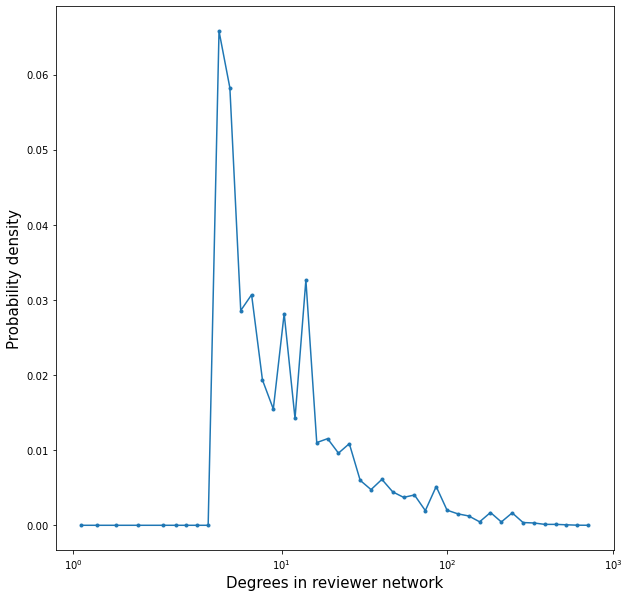

In [132]:
# plot histogram
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(x, hist, marker=".")
ax.set_xlabel("Degrees in reviewer network", size=15)
ax.set_ylabel("Probability density", size=15)
ax.set_xscale("symlog")
# ax.set_yscale("symlog")

## Degree distribution for random network

In [127]:
bins = np.logspace(np.log10(40), np.log10(140), 30) # logarithmic binning
# make histogram
hist, edges = np.histogram([i[1] for i in randomG.degree], bins=bins, density=True)
# make midpoints and width
x = (edges[1:] + edges[:-1]) / 2
width = bins[1]-bins[0]

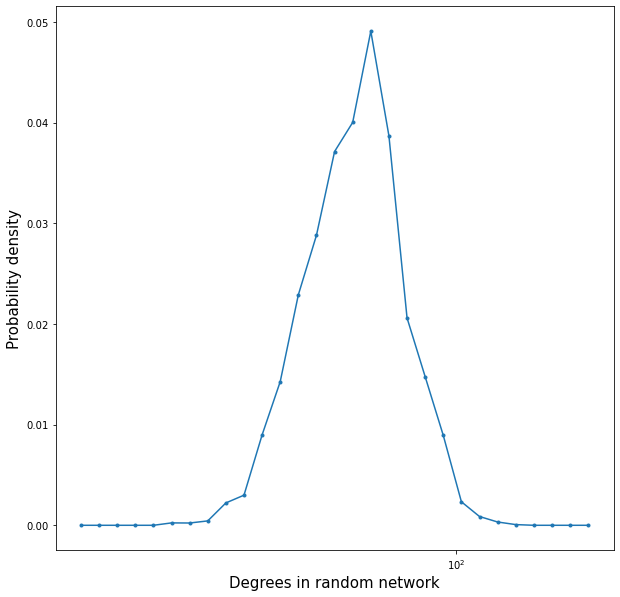

In [128]:
# plot histogram
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(x, hist, marker=".")
ax.set_xlabel("Degrees in random network", size=15)
ax.set_ylabel("Probability density", size=15)
ax.set_xscale("symlog")
# ax.set_yscale("symlog")

In [147]:
print("The average degree for the reviwer network is:", np.mean(list(dict(G.degree()).values())))
print("The average degree for the random network is:", np.mean(list(dict(randomG.degree()).values())))

The average degree for the reviwer network is: 79.60055430452104
The average degree for the random network is: 79.8406374501992


Both networks have around the same average degree, but their distributions vary. The degree distribution for the reviewer network is much more spread out, with degrees ranging from 4 to 755, and skewered towards the left, indicating that smaller degrees are most frequent. The degree distribution for the random network is approximately a normal distribution where both smaller and larger degrees are infrequent.

Using equation 2.15, the local clustering coefficient for a node $i$ is computed as:
$$
\begin{equation}
C_i = \frac{2\cdot L_i}{k_i(k_i-1)}
\end{equation}
$$
where $L_i$ is the number of edges node $i$ has to its $k_i$ neighbours.

The average clustering coefficient is found by averaging the local clustering coefficinet for all nodes. This is computed for both the reviewer network and the random network.

In [31]:
#Compute clustering coefficient using equation 2.15
CClist1 = []
for node in G.nodes():
    K = len(list(nx.neighbors(G,node)))
    L = nx.triangles(G,node)
    if K > 1:
        CClist1.append(2*L/(K*(K-1)))
    elif K == 1:
        CClist1.append(0)


In [32]:
print("The average clustering coefficient for the reviewer network is:",np.mean(CClist1))

The average clustering coefficient for the reviewer network is: 0.88288368830766


In [29]:
#Compute clustering coefficient using equation 2.15
CClist = []
for node in randomG.nodes():
    K = len(list(nx.neighbors(randomG,node)))
    L = nx.triangles(randomG,node)
    if K > 1:
        CClist.append(2*L/(K*(K-1)))
    elif K == 1:
        CClist.append(0)

In [30]:
print("The average clustering coefficient for the random network is:",np.mean(CClist))

The average clustering coefficient for the random network is: 0.0138553768995449


In [33]:
print("The average clustering coefficient for the random network is:", nx.average_clustering(randomG))
print("The average clustering coefficient for the reviewer network is:",nx.average_clustering(G))

The average clustering coefficient for the random network is: 0.013855376899544967
The average clustering coefficient for the reviewer network is: 0.8828836883076604


We see that the average clustering coefficient is much larger for the reviewer network than the random network with a similar amount of nodes and edges, as expected. According to [network book], real life networks have much higher average clustering coefficient than a random networks with similar amount of nodes and edges.

# Related Products Network

In [11]:
product_df3 = pd.read_csv("data/product_df3.csv")
product_df3

asin                                        description  \
0       616719923X  Green Tea Flavor Kit Kat have quickly become t...   
1       616719923X  Green Tea Flavor Kit Kat have quickly become t...   
2       616719923X  Green Tea Flavor Kit Kat have quickly become t...   
3       616719923X  Green Tea Flavor Kit Kat have quickly become t...   
4       616719923X  Green Tea Flavor Kit Kat have quickly become t...   
...            ...                                                ...   
380298  B00K00H9I6  Harvested from the iconic snowy woods of Quebe...   
380299  B00K00H9I6  Harvested from the iconic snowy woods of Quebe...   
380300  B00K00H9I6  Harvested from the iconic snowy woods of Quebe...   
380301  B00KC0LGI8                                                NaN   
380302  B00KCJRVO2  Enjoy your gluten freedom. Chex Gluten Free Oa...   

                                                    title  \
0       Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...   
1       Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...   
2       Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...   
3       Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...   
4       Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...   
...                                                   ...   
380298  Canadian Finest Maple Syrup - 100% Pure Certif...   
380299  Canadian Finest Maple Syrup - 100% Pure Certif...   
380300  Canadian Finest Maple Syrup - 100% Pure Certif...   
380301  Betty Crocker Dry Meals Suddenly Grain Salad, ...   
380302  General Mills Cereals Chex Gluten Free Oatmeal...   

                                                    imUrl  \
0       http://ecx.images-amazon.com/images/I/51LdEao6...   
1       http://ecx.images-amazon.com/images/I/51LdEao6...   
2       http://ecx.images-amazon.com/images/I/51LdEao6...   
3       http://ecx.images-amazon.com/images/I/51LdEao6...   
4       http://ecx.images-amazon.com/images/I/51LdEao6...   
...                                                   ...   
380298  http://ecx.images-amazon.com/images/I/41abh7Ho...   
380299  http://ecx.images-amazon.com/images/I/41abh7Ho...   
380300  http://ecx.images-amazon.com/images/I/41abh7Ho...   
380301  http://ecx.images-amazon.com/images/I/61zqxqJi...   
380302  http://ecx.images-amazon.com/images/I/51r064m2...   

                                                  related  \
0       {'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...   
1       {'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...   
2       {'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...   
3       {'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...   
4       {'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...   
...                                                   ...   
380298  {'also_bought': ['B005P0LW66', 'B00JEKYNZA', '...   
380299  {'also_bought': ['B005P0LW66', 'B00JEKYNZA', '...   
380300  {'also_bought': ['B005P0LW66', 'B00JEKYNZA', '...   
380301  {'also_viewed': ['B00KSKIHVG', 'B00JWWM1T0', '...   
380302  {'also_viewed': ['B00LG89RX6', 'B00LG8GDQU', '...   

                                 salesRank                    categories  \
0        {'Grocery & Gourmet Food': 37305}  [['Grocery & Gourmet Food']]   
1        {'Grocery & Gourmet Food': 37305}  [['Grocery & Gourmet Food']]   
2        {'Grocery & Gourmet Food': 37305}  [['Grocery & Gourmet Food']]   
3        {'Grocery & Gourmet Food': 37305}  [['Grocery & Gourmet Food']]   
4        {'Grocery & Gourmet Food': 37305}  [['Grocery & Gourmet Food']]   
...                                    ...                           ...   
380298    {'Grocery & Gourmet Food': 1500}  [['Grocery & Gourmet Food']]   
380299    {'Grocery & Gourmet Food': 1500}  [['Grocery & Gourmet Food']]   
380300    {'Grocery & Gourmet Food': 1500}  [['Grocery & Gourmet Food']]   
380301   {'Grocery & Gourmet Food': 97624}  [['Grocery & Gourmet Food']]   
380302  {'Grocery & Gourmet Food': 157656}  [['Grocery & Gourmet Food']]   

        price brand relat

In [60]:
idx = []
categories = []
categories2 = {}
for i in range(len(product_df3)):
    if str(product_df3.iloc[i]['categories']) == str([['Grocery & Gourmet Food']]):
        idx.append(i)
    else:
        h = product_df3.iloc[i]['categories']
        h = h.replace("[","").replace("]","").replace(" '","").replace("'", "")
        h = h.split(",")
        
        categories2[product_df3['asin'].iloc[i]] = h[1]
        
        categories.append(h[1])
        

In [61]:
# remove indices in original df
product_df4 = product_df3.drop(idx)
# make a new column
product_df5 = product_df4.assign(category=categories)
# explode column related_products
product_df5
product_df5.to_csv("data/product_df5.csv", index=False)

In [62]:
product_df5 = pd.read_csv("data/product_df5.csv")
product_df5

asin                                        description  \
0      B00004S1C5  From Easter eggs to colorful cookies, Spectrum...   
1      B00004S1C5  From Easter eggs to colorful cookies, Spectrum...   
2      B00004S1C5  From Easter eggs to colorful cookies, Spectrum...   
3      B00004S1C5  From Easter eggs to colorful cookies, Spectrum...   
4      B00004S1C5  From Easter eggs to colorful cookies, Spectrum...   
...           ...                                                ...   
13541  B00JGPG60I  Enfamil Reguline is an everyday formula that g...   
13542  B00JGPG60I  Enfamil Reguline is an everyday formula that g...   
13543  B00JGPG60I  Enfamil Reguline is an everyday formula that g...   
13544  B00JGPG60I  Enfamil Reguline is an everyday formula that g...   
13545  B00JGPG60I  Enfamil Reguline is an everyday formula that g...   

                                                   title  \
0                      Ateco Food Coloring Kit, 6 colors   
1                      Ateco Food Coloring Kit, 6 colors   
2                      Ateco Food Coloring Kit, 6 colors   
3                      Ateco Food Coloring Kit, 6 colors   
4                      Ateco Food Coloring Kit, 6 colors   
...                                                  ...   
13541  Enfamil Reguline Milk-Based Powder with Iron I...   
13542  Enfamil Reguline Milk-Based Powder with Iron I...   
13543  Enfamil Reguline Milk-Based Powder with Iron I...   
13544  Enfamil Reguline Milk-Based Powder with Iron I...   
13545  Enfamil Reguline Milk-Based Powder with Iron I...   

                                                   imUrl  \
0      http://ecx.images-amazon.com/images/I/41F75K9F...   
1      http://ecx.images-amazon.com/images/I/41F75K9F...   
2      http://ecx.images-amazon.com/images/I/41F75K9F...   
3      http://ecx.images-amazon.com/images/I/41F75K9F...   
4      http://ecx.images-amazon.com/images/I/41F75K9F...   
...                                                  ...   
13541  http://ecx.images-amazon.com/images/I/510zYVQ8...   
13542  http://ecx.images-amazon.com/images/I/510zYVQ8...   
13543  http://ecx.images-amazon.com/images/I/510zYVQ8...   
13544  http://ecx.images-amazon.com/images/I/510zYVQ8...   
13545  http://ecx.images-amazon.com/images/I/510zYVQ8...   

                                                 related  \
0      {'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...   
1      {'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...   
2      {'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...   
3      {'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...   
4      {'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...   
...                                                  ...   
13541  {'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...   
13542  {'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...   
13543  {'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...   
13544  {'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...   
13545  {'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...   

                               salesRank  \
0             {'Kitchen & Dining': 4494}   
1             {'Kitchen & Dining': 4494}   
2             {'Kitchen & Dining': 4494}   
3             {'Kitchen & Dining': 4494}   
4             {'Kitchen & Dining': 4494}   
...                                  ...   
13541  {'Health & Personal Care': 13464}   
13542  {'Health & Personal Care': 13464}   
13543  {'Health & Personal Care': 13464}   
13544  {'Health & Personal Care': 13464}   
13545  {'Health & Personal Care': 13464}   

                                              categories  price  \
0      [['Grocery & Gourmet Food', 'Cooking & Baking'...   9.76   
1      [['Grocery & Gourmet Food', 'Cooking & Baking'...   9.76   
2      [['Grocery & Gourmet Food', 'Cooking & Baking'...   9.76   
3      [['Grocery & Gourmet Food', 'Cooking & Baking'...   9.76   
4      [['Grocery & Gourmet Food', 'Cooking & Baking'...   9.76   
...                                                  .

In [63]:
# group by asin and related_products
grouped_df = product_df5.groupby(["asin", "related_products"]).count()

grouped_df.index

MultiIndex([('B00004S1C5', 'B0000CFN0Y'),
            ('B00004S1C5', 'B0001BGTSA'),
            ('B00004S1C5', 'B0001M0YK8'),
            ('B00004S1C5', 'B0001XXB3E'),
            ('B00004S1C5', 'B000OZFECU'),
            ('B00004S1C5', 'B000R4LONQ'),
            ('B00004S1C5', 'B0012DMI1S'),
            ('B00004S1C5', 'B0019N87XE'),
            ('B00004S1C5', 'B0029YDR82'),
            ('B00004S1C5', 'B002PO3KBK'),
            ...
            ('B00HQ3ZPJA', 'B00H889MGK'),
            ('B00JGPG60I', 'B000BIUH18'),
            ('B00JGPG60I', 'B000BIUH1I'),
            ('B00JGPG60I', 'B002IYDXW8'),
            ('B00JGPG60I', 'B0039NMF9E'),
            ('B00JGPG60I', 'B003TN6ZN6'),
            ('B00JGPG60I', 'B003U9MCQI'),
            ('B00JGPG60I', 'B003VKR0HM'),
            ('B00JGPG60I', 'B0055QVU6M'),
            ('B00JGPG60I', 'B00FB5CUY8')],
           names=['asin', 'related_products'], length=10625)

In [64]:
o = {}
nancount = 0
for i in range(len(product_df5)):
    if str(product_df5['related_products'].iloc[i]) != 'nan':
        abe = tuple([product_df5.iloc[i]['asin'], product_df5.iloc[i]['related_products']])
        if abe not in o.keys():
            o[abe] = 0
        o[abe] += 1
    else:
        nancount += 1
        
len(o)

10625

In [65]:
# make sure all nans have been sorted
sum(o.values())+nancount

13546

In [99]:
# create weighted edges for directed graph
# weighted_edges = [(a, pa, c) for (a, pa), c  in zip(list(grouped_df.index), list(grouped_df.description))]
edges = o.keys()

G = nx.Graph()
G.add_nodes_from(product_df5['asin'])
G.add_edges_from(edges)

In [176]:
# make attribute names
colour_dict = {'Baby Foods': '#6efa85',
              'Beverages': '#92db5d',
              'Breakfast Foods': '#a3bc40',
              'Candy & Chocolate': '#a89e30',
              'Canned': '#a5812b',
              'Cooking & Baking': '#9a662c',
              'Fresh Flowers & Live Indoor Plants': '#894f2d',
              'Gourmet Gifts': '#723b2d',
              'Snack Foods': '#582a2a'}

# colour_dict = {'Baby Foods': 'red',
#               'Beverages': 'blue',
#               'Breakfast Foods': 'yellow',
#               'Candy & Chocolate': 'orange',
#               'Canned': 'magenta',
#               'Cooking & Baking': 'green',
#               'Fresh Flowers & Live Indoor Plants': 'purple',
#               'Gourmet Gifts': 'black',
#               'Snack Foods': 'navy'}



cat = {}
for node in G.nodes():
    if node in categories2.keys():
        cat[node] = colour_dict[categories2[node]]
    else:
        cat[node] = '#9e9e9e'

nx.set_node_attributes(G, cat, name='category')

In [177]:
cat

{'B00004S1C5': '#9a662c',
 'B0000CD06J': '#92db5d',
 'B0000CFN0Y': '#9a662c',
 'B0000CFPI2': '#582a2a',
 'B0000DGF9V': '#894f2d',
 'B00014CZQC': '#92db5d',
 'B00014D37W': '#9a662c',
 'B00014CZP8': '#a5812b',
 'B00014DJL2': '#a5812b',
 'B00014DV6A': '#92db5d',
 'B00014EO2A': '#9a662c',
 'B00014HS2S': '#92db5d',
 'B00014JNI0': '#9a662c',
 'B00016RH40': '#9a662c',
 'B0001GDE1K': '#92db5d',
 'B0001M0Y1M': '#9a662c',
 'B0001M0YK8': '#a5812b',
 'B0001XXB3E': '#9a662c',
 'B00024CW1O': '#9a662c',
 'B00025K10W': '#9a662c',
 'B00028Q45A': '#a5812b',
 'B00028Q9NW': '#92db5d',
 'B0002DU87K': '#a5812b',
 'B0002JFTNM': '#9a662c',
 'B0004LZMOY': '#a5812b',
 'B0005ZXPY8': '#9a662c',
 'B00068PCTU': '#9a662c',
 'B0006Z7NNG': '#9a662c',
 'B0007KNXGQ': '#a5812b',
 'B0007LXU8Q': '#a3bc40',
 'B0007SMLUM': '#a5812b',
 'B0009EXZBS': '#9a662c',
 'B0009F3POY': '#92db5d',
 'B0009JRKDC': '#9a662c',
 'B0009O7802': '#a3bc40',
 'B000A3I3BA': '#9a662c',
 'B000AF0A78': '#92db5d',
 'B000BD0SDU': '#a5812b',
 'B000BFJ41U

In [178]:
list(np.unique(list(categories2.values())))

['Baby Foods',
 'Beverages',
 'Breakfast Foods',
 'Candy & Chocolate',
 'Canned',
 'Cooking & Baking',
 'Fresh Flowers & Live Indoor Plants',
 'Gourmet Gifts',
 'Snack Foods']

In [179]:
missing = []
for node in product_df5['related_products']:
    if node not in list(G.nodes()):
        if node not in missing:
            print(node)
            missing.append(node)
            
len(missing)

nan


1

In [180]:
H = nx.Graph()
H.add_nodes_from(product_df5['asin'])
H.number_of_nodes()

358

In [181]:
# we don't want nan node so subtract 1
8456+(30-1)

8485

In [182]:
# number of nodes
n_nodes = G.number_of_nodes()
print("number of nodes:", n_nodes)
# number of edges
n_edges = G.number_of_edges()
print("number of edges:", n_edges)

# density
L_max = n_nodes * (n_nodes - 1)
density = n_edges / L_max
print("network density: {:2f}".format(density))

number of nodes: 2814
number of edges: 10168
network density: 0.001285


In [183]:
# degree
print("mean degree", np.mean([i[1] for i in G.degree()]))
print("median degree", np.median([i[1] for i in G.degree()]))
print("mode of degree", stats.mode([i[1] for i in G.degree()]).mode[0])
print("min degree", np.min([i[1] for i in G.degree()]))
print("max degree", np.max([i[1] for i in G.degree()]))

mean degree 7.226723525230988
median degree 2.0
mode of degree 1
min degree 0
max degree 108


In [204]:
network = nw.get_filtered_network(G, node_group_key="category")
stylized_network, config = nw.visualize(network, plot_in_cell_below=False)

In [200]:
legend = {'B001A1VIUO': 'BABY BLUE', 
         'B000BIUH1I': 'PINK',
         'B0013307IA': 'BLUE',
         'B002YLINLG': 'CYAN',
         'B002EITVVA': 'MAROON',
         'B000EVNYQ2': 'MAGENTA',
         'B005XB145Q': 'GREY GREEN',
         'B009GCXEW4': 'NAVY',
         }

for product in products:
    print(cat[product])


#a3bc40
#6efa85
#a5812b
#a89e30
#a3bc40
#582a2a
#6efa85
#9a662c
#92db5d
#723b2d


TypeError: 'NoneType' object is not subscriptable

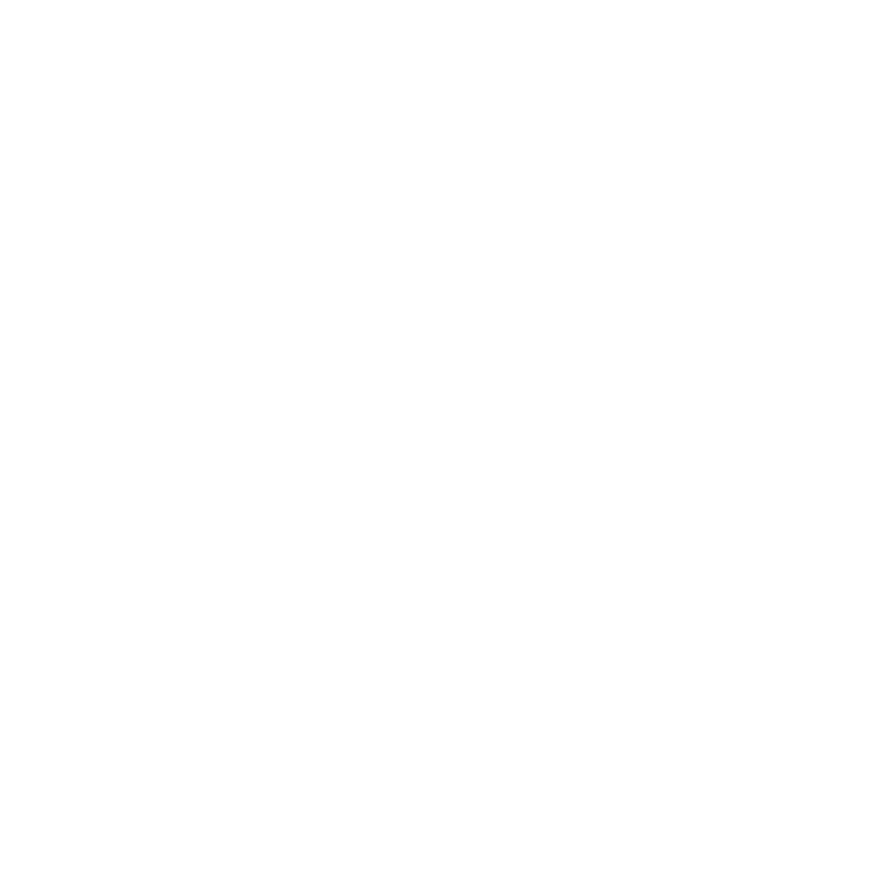

In [201]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

In [209]:
import numpy as np
import community as community_louvain
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph

#first compute the best partition
partition = community_louvain.best_partition(G)

# number of communities in the partition
len(np.unique(list(partition.values())))



30

In [210]:
def computeModularity(G, partition):

    partitions = np.unique(list(nx.get_node_attributes(G,partition).values()))
    partition_dic = {part: [] for part in partitions}
    
    N = len(G.nodes())
    L = len(G.edges())
    
#     modularity = 0
    modularity = []
    for key in partition_dic.keys():
        for node in G.nodes():
            part = G.nodes[node][partition]
            partition_dic[part].append(node)
        community = nx.Graph.subgraph(G, partition_dic[key])
        k_c = sum([G.degree(v) for v in community])
        L_c = len(community.edges())


#         modularity += (L_c / L) - (k_c/(2*L))**2
        modularity.append((L_c / L) - (k_c/(2*L))**2)
        
    return sum(modularity), modularity

In [211]:
print("modularity of category partition:", computeModularity(G, 'category')[0])
H = G.copy()
nx.set_node_attributes(H, partition, 'Louvain')

modularity, _ = computeModularity(H, 'Louvain')
print("The modularity of the louvain split network is:", modularity)

modularity of category partition: -0.2012784647504923
The modularity of the louvain split network is: 0.660324134207006


In [212]:
# let's look at some modularities for each community in G.
computeModularity(G, 'category')[1]

[0.00034601377812622084,
 0.00852668675302905,
 -2.3237656157049376e-06,
 -9.672281438938345e-09,
 -5.966104998573335e-05,
 -0.01310323311095856,
 -0.20129801243128037,
 -0.00013557636892959883,
 -0.0008254034811546809,
 0.005273054598558536]

The modularity $M_c$ for each community $c$ in the network G is negative. According to the textbook [networksciencebook], this means the subgraph $C_c$ for community $c$ has less links than expected by chance. Based on the modularity, we can conclude that the category is not a good partition of the network G.

In [132]:
network = nw.get_filtered_network(H, node_group_key="Louvain")
stylized_network, config = nw.visualize(network, plot_in_cell_below=False)

In [134]:
fig, ax = nw.draw_netwulf(stylized_network, figsize=12)

# Reviewer/edge network

# Sentiment analysis

In [38]:
Counter(list(product_df5['category']))

Counter({'Cooking & Baking': 5224,
         'Beverages': 2735,
         'Snack Foods': 1107,
         'Fresh Flowers & Live Indoor Plants': 3,
         'Canned': 2653,
         'Breakfast Foods': 523,
         'Baby Foods': 230,
         'Candy & Chocolate': 1042,
         'Gourmet Gifts': 29})

In [40]:
product_df2 = pd.read_csv("data/product_df2.csv")

In [41]:
product_df2

asin                                        description  \
0     616719923X  Green Tea Flavor Kit Kat have quickly become t...   
1     9742356831  Used to make various curry soups and stir fry ...   
2     B00004S1C5  From Easter eggs to colorful cookies, Spectrum...   
3     B0000531B7                                                NaN   
4     B00005344V  For nearly forty years, we&#x2019;ve been pass...   
...          ...                                                ...   
8451  B00JGPG60I  Enfamil Reguline is an everyday formula that g...   
8452  B00JL6LTMW  The street corners of big cities are sprinkled...   
8453  B00K00H9I6  Harvested from the iconic snowy woods of Quebe...   
8454  B00KC0LGI8                                                NaN   
8455  B00KCJRVO2  Enjoy your gluten freedom. Chex Gluten Free Oa...   

                                                  title  \
0     Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...   
1           Mae Ploy Thai Green Curry Paste - 14 oz jar   
2                     Ateco Food Coloring Kit, 6 colors   
3     PowerBar Harvest Energy Bars, Double Chocolate...   
4     Traditional Medicinals Breathe Easy, 16-Count ...   
...                                                 ...   
8451  Enfamil Reguline Milk-Based Powder with Iron I...   
8452  Larabar Renola Grain-Free Granola, Cinnamon Nu...   
8453  Canadian Finest Maple Syrup - 100% Pure Certif...   
8454  Betty Crocker Dry Meals Suddenly Grain Salad, ...   
8455  General Mills Cereals Chex Gluten Free Oatmeal...   

                                                  imUrl  \
0     http://ecx.images-amazon.com/images/I/51LdEao6...   
1     http://ecx.images-amazon.com/images/I/41pQp67A...   
2     http://ecx.images-amazon.com/images/I/41F75K9F...   
3     http://ecx.images-amazon.com/images/I/519SuVj1...   
4     http://ecx.images-amazon.com/images/I/51H54cd-...   
...                                                 ...   
8451  http://ecx.images-amazon.com/images/I/510zYVQ8...   
8452  http://ecx.images-amazon.com/images/I/4114WeHd...   
8453  http://ecx.images-amazon.com/images/I/41abh7Ho...   
8454  http://ecx.images-amazon.com/images/I/61zqxqJi...   
8455  http://ecx.images-amazon.com/images/I/51r064m2...   

                                                related  \
0     {'also_bought': ['B00FD63L5W', 'B0047YG5UY', '...   
1     {'also_bought': ['B000EI2LLO', 'B000EICISA', '...   
2     {'also_bought': ['B0000CFMLT', 'B002PO3KBK', '...   
3     {'also_bought': ['B000EC63PU', 'B00DZGEY44', '...   
4     {'also_bought': ['B0009F3POE', 'B0009F3POO', '...   
...                                                 ...   
8451  {'also_bought': ['B003VKYGOM', 'B00CTKKB1C', '...   
8452  {'also_bought': ['B00BCNTCHG', '1628600101', '...   
8453  {'also_bought': ['B005P0LW66', 'B00JEKYNZA', '...   
8454  {'also_viewed': ['B00KSKIHVG', 'B00JWWM1T0', '...   
8455  {'also_viewed': ['B00LG89RX6', 'B00LG8GDQU', '...   

                               salesRank  \
0      {'Grocery & Gourmet Food': 37305}   
1       {'Grocery & Gourmet Food': 3434}   
2             {'Kitchen & Dining': 4494}   
3       {'Grocery & Gourmet Food': 2858}   
4       {'Grocery & Gourmet Food': 5034}   
...                                  ...   
8451   {'Health & Personal Care': 13464}   
8452    {'Grocery & Gourmet Food': 9344}   
8453    {'Grocery & Gourmet Food': 1500}   
8454   {'Grocery & Gourmet Food': 97624}   
8455  {'Grocery & Gourmet Food': 157656}   

                                             categories  price  \
0                          [['Grocery & Gourmet Food']]    NaN   
1                          [['Grocery & Gourmet Food']]   7.23   
2     [['Grocery & Gourmet Food', 'Cooking & Baking'...   9.76   
3                          [['Grocery & Gourmet Food']]  24.75   
4                          [['Grocery & Gourmet Food']]  21.74   
...                                                 ...    ...   
8451  [['Grocery & Gourmet Food', 'Baby F

In [43]:
# remove indices with no subcategories
idx = []
# subcategories
categories = []
for i in range(len(product_df2)):
    if str(product_df2.iloc[i]['categories']) == str([['Grocery & Gourmet Food']]):
        idx.append(i)
    else:
        h = product_df2.iloc[i]['categories']
        h = h.replace("[","").replace("]","").replace(" '","").replace("'", "")
        h = h.split(",")
        
        categories.append(h[1])

In [52]:
# remove indices in original df
product_df6 = product_df2.drop(idx)
# make a new column
product_df7 = product_df6.assign(category=categories)
product_df7.to_csv("data/product_df7.csv", index=False)

In [56]:
print("Amount of products with subcategories: ", len(product_df7))

amount of products with subcategories:  358


In [95]:
review_df['text'] = review_df['reviewText'] + ' ' + review_df['summary']

reviewerID        asin  \
0       A1VEELTKS8NLZB  616719923X   
1       A14R9XMZVJ6INB  616719923X   
2       A27IQHDZFQFNGG  616719923X   
3       A31QY5TASILE89  616719923X   
4       A2LWK003FFMCI5  616719923X   
...                ...         ...   
151249  A2L6QS8SVHT9RG  B00KCJRVO2   
151250   AFJFXN42RZ3G2  B00KCJRVO2   
151251   ASEBX8TBYWQWA  B00KCJRVO2   
151252   ANKQGTXHREOI5  B00KCJRVO2   
151253  A2CF66KIQ3RKX3  B00KCJRVO2   

                                            reviewerName helpful  \
0                                        Amazon Customer  [0, 0]   
1                                                amf0001  [0, 1]   
2                                                Caitlin  [3, 4]   
3                                           DebraDownSth  [0, 0]   
4                                               Diana X.  [1, 2]   
...                                                  ...     ...   
151249              randomartco "period film aficionado"  [0, 0]   
151250                               R. DelParto "Rose2"  [0, 0]   
151251  Steven I. Ramm "Steve Ramm &#34;Anything Phon...  [1, 1]   
151252                                     Titanium Lili  [0, 1]   
151253                                      Vivian Deliz  [0, 0]   

                                               reviewText  overall  \
0       Just another flavor of Kit Kat but the taste i...      4.0   
1       I bought this on impulse and it comes from Jap...      3.0   
2       Really good. Great gift for any fan of green t...      4.0   
3       I had never had it before, was curious to see ...      5.0   
4       I've been looking forward to trying these afte...      4.0   
...                                                   ...      ...   
151249  Delicious gluten-free oatmeal: we tried both t...      4.0   
151250  With the many selections of instant oatmeal ce...      4.0   
151251  While I usually review CDs and DVDs, as well a...      5.0   
151252  My son and I enjoyed these oatmeal packets.  H...      4.0   
151253  I like to eat oatmeal i the mornings. I usuall...      4.0   

                                                  summary  unixReviewTime  \
0                                              Good Taste      1370044800   
1       3.5 stars,  sadly not as wonderful as I had hoped      1400457600   
2                                                    Yum!      1381190400   
3                                  Unexpected flavor meld      1369008000   
4       Not a very strong tea flavor, but still yummy ...      1369526400   
...                                                   ...             ...   
151249       Delicious gluten-free oatmeal 'quick' packs!      1405123200   
151250                             Convenient and Instant      1404604800   
151251  Compares favorably in taste and texture with o...      1404172800   
151252                                       Pretty good!      1404432000   
151253               I like to eat oatmeal i the mornings      1405036800   

         reviewTime                                               text  
0        06 1, 2013  Just another flavor of Kit Kat but the taste i...  
1       05 19, 2014  I bought this on impulse and it comes from Jap...  
2        10 8, 2013  Really good. Great gift for any fan of green t...  
3       05 20, 2013  I had never had it before, was curious to see ...  
4       05 26, 2013  I've been looking forward to trying these afte...  
...             ...                                                ...  
151249  07 12, 2014  Delicious gluten-free oatmeal: we tried both t...  
151250   07 6, 2014  With the many selections of instant oatmeal ce...  
151251   07 1, 2014  While I usually review CDs and DVDs, as well a...  
151252   07 4, 2014  My son and I enjoyed these oatmeal packets.  H...  
151253  07 11, 2014  I like to eat oatmeal i the mornings. I usuall...  

[151254 rows x 10 columns]

In [98]:
review_df['text'][1]

"I bought this on impulse and it comes from Japan,  which amused my family,  all those weird stamps and markings on the package. So that was fun.  It said it would take about a month to arrive and it did take that long.  I was hoping for a more interesting taste but to our family,  it just tasted a bit less flavorful or weaker than the standard milk chocolate kit kat.  The green tea flavor was too subtle for the sugar and it just tasted sweet. The wafers were very crispy, and that was good,  but it tasted a bit anemic to us.I'm happy I bought it, but don't need to buy it again. 3.5 stars,  sadly not as wonderful as I had hoped"

In [161]:
# # # clean the text:
# &#34 = quotation mark
# / remove all
# add space after ! and .


# tokenise text
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
alphabet = "abcdefghijklmnopqrstuvwxyz"
# URL1 = '.com'
# URL2 = 'www.'
# URL3 = 'https'
# URL4 = '='
# URL5 = '.'
# char1 = 'amp' # a part of "&amp" which means ampersand in HTML
# char2 = 'x200b' # character code for zero width space
# char3 = 'gt' # greater than
# char4 = 'lt' # less than


all_reviews = []
for text in review_df['text']:
    tokens = word_tokenize(text)
    review = []
    for token in tokens:
        token = token.lower()
        # remove stopwords, punctuation and numbers
        if token not in stopwords and token[0] in alphabet and token[-1] in alphabet:
            # remove URLs
            review.append(token)
    all_reviews.append(review)

review_df['tokens'] = all_reviews

In [166]:
review_df.iloc[0]['tokens']

['another',
 'flavor',
 'kit',
 'kat',
 'taste',
 'unique',
 'bit',
 'different',
 'thing',
 'bothersome',
 'price',
 'thought',
 'bit',
 'expensive',
 'good',
 'taste']

In [167]:
prod_dict = {}
for product in product_df7['asin']:
    prod_dict[product] = []
    
for i in range(len(review_df)):
    prod = review_df.iloc[i]['asin']
    if prod in prod_dict:
        review = review_df.iloc[i]['tokens']
        prod_dict[prod].extend(review)

In [168]:
prod_dict[product_df7['asin'].iloc[0]]

['dyes',
 'create',
 'awesome',
 'colors',
 'kids',
 'crafts',
 'used',
 'make',
 'finger',
 'paint',
 'paint',
 'play',
 'dough',
 'salt',
 'dough.another',
 'reviewer',
 'stated',
 'natural',
 'correct',
 'definitely',
 'artificial',
 'dyes',
 'tried',
 'making',
 'dyes',
 'fell',
 'worked',
 'great',
 'pinch',
 'need',
 'couple',
 'drops',
 'really',
 'vibrant',
 'color',
 'pretty',
 'easy',
 'clean',
 "n't",
 'stain',
 'made',
 'whatever',
 'craft.good',
 'product',
 'price',
 'great',
 'kids',
 'crafts',
 'product',
 'near',
 'natural',
 'organic-i',
 'wish',
 'seen',
 'reviews',
 'purchasing',
 'contains',
 'things',
 'want-which',
 'looking',
 'natural',
 'alternative',
 'need',
 'ingredient',
 'list',
 'avoid',
 'returning',
 'item',
 'trying',
 'avoid',
 'children',
 'exposure',
 'yellow',
 'red',
 'understand',
 'still',
 'make',
 'things',
 'knowing',
 'cause',
 'may',
 'fine',
 'someone',
 "n't",
 'read',
 'labels',
 'care',
 'kids',
 'eat-but',
 'family',
 'natural/organic

In [170]:
cat_dict = {}
for cat in np.unique(categories):
    cat_dict[cat] = []

for prod in prod_dict.keys():
    cat = product_df7.iloc[np.where(product_df7['asin']==prod)]['category'].iloc[0]
    cat_dict[cat].extend(prod_dict[prod])

In [176]:
for key in cat_dict.keys():
    print('N tokens, {0}: {1}'.format(key, len(cat_dict[key])))

N tokens, Baby Foods: 37730
N tokens, Beverages: 72767
N tokens, Breakfast Foods: 7766
N tokens, Candy & Chocolate: 8798
N tokens, Canned: 45528
N tokens, Cooking & Baking: 85302
N tokens, Fresh Flowers & Live Indoor Plants: 257
N tokens, Gourmet Gifts: 246
N tokens, Snack Foods: 12227


In [179]:
for key in cat_dict.keys():
    print("Category:", key)
    a = dict(Counter(cat_dict[key],sorted=True))
    print(sorted(a, key=a.get, reverse=True)[:5])
    counts = sorted(a.values(), reverse=True)[:5]
    tf = [count/len(cat_dict[key]) for count in counts]
    print(np.round(tf,3))
    print("\n")

Category: Baby Foods
['formula', 'milk', "n't", 'baby', 'like']
[0.029 0.014 0.014 0.013 0.009]


Category: Beverages
['tea', "n't", 'like', 'good', 'coffee']
[0.026 0.013 0.012 0.011 0.01 ]


Category: Breakfast Foods
['bars', 'bar', 'like', 'good', "n't"]
[0.025 0.02  0.019 0.015 0.015]


Category: Candy & Chocolate
['gum', 'flavor', 'good', "n't", 'great']
[0.033 0.019 0.015 0.014 0.014]


Category: Canned
['salt', "n't", 'taste', 'good', 'like']
[0.016 0.012 0.01  0.01  0.01 ]


Category: Cooking & Baking
['oil', 'coconut', 'use', "n't", 'like']
[0.014 0.012 0.011 0.011 0.01 ]


Category: Fresh Flowers & Live Indoor Plants
['tree', 'nice', 'light', 'bonsai', 'ficus']
[0.054 0.019 0.019 0.019 0.016]


Category: Gourmet Gifts
['love', 'cups', 'looks', 'coffee', 'holds']
[0.028 0.024 0.024 0.02  0.02 ]


Category: Snack Foods
['fruit', 'like', 'good', 'great', "n't"]
[0.019 0.014 0.014 0.012 0.012]




In [185]:
# Make IDF dict
document_freq_dic = {}
IDF = {}
N = len(cat_dict)
for key in cat_dict.keys():
    print("Category:",key)
    unique_term = np.unique(cat_dict[key])
    for t in unique_term:
        if t not in document_freq_dic.keys():
            document_freq_dic[t] = 0
        document_freq_dic[t] += 1
        IDF[t] = np.log(N/document_freq_dic[t])
        
        
df_document_freq = pd.DataFrame.from_dict(document_freq_dic, orient='index', columns=['doc_freq'])
df_document_freq.to_csv("document_freq.csv")

df_idf = pd.DataFrame.from_dict(IDF, orient='index', columns=['IDF'])
df_idf.to_csv("IDF.csv")

Category: Baby Foods
Category: Beverages
Category: Breakfast Foods
Category: Candy & Chocolate
Category: Canned
Category: Cooking & Baking
Category: Fresh Flowers & Live Indoor Plants
Category: Gourmet Gifts
Category: Snack Foods


In [187]:
IDF_df = pd.read_csv("IDF.csv", index_col=0)
IDF_df

IDF
a.r                 1.504077
abbreviated         2.197225
abdominal           1.098612
ability             0.587787
able                0.117783
...                      ...
young-at-heart      2.197225
yourtypical         2.197225
yummmmm             2.197225
z-bars              2.197225
zing.unfortunately  2.197225

[19405 rows x 1 columns]

In [190]:
for key in cat_dict.keys():
    unique_terms = np.unique(cat_dict[key])
    TF_IDF = {}
    # top 10 TF for each stock
    print("Category:", key)
    print("Top 10 TF words")
    a = dict(Counter(cat_dict[key],sorted=True))
    print(sorted(a, key=a.get, reverse=True)[:10])
    counts = sorted(a.values(), reverse=True)[:10]
    tf = [count/len(cat_dict[key]) for count in counts]
    print(np.round(tf,3))


    # top 10 TF-IDF for each stock
    for t in unique_terms:
        if t in IDF_df.index:
            tf = a[t]/len(cat_dict[key])
            TF_IDF[t] = IDF_df['IDF'][t] * tf
    print("Top 10 TF-IDF words")
    print(sorted(TF_IDF, key=TF_IDF.get, reverse=True)[:10])
    b = sorted(TF_IDF.values(), reverse=True)[:10]
    print(np.round(b,3))
    print("\n")

Category: Baby Foods
Top 10 TF words
['formula', 'milk', "n't", 'baby', 'like', 'enfamil', 'corn', 'good', 'syrup', 'one']
[0.029 0.014 0.014 0.013 0.009 0.009 0.008 0.008 0.008 0.008]
Top 10 TF-IDF words
['formula', 'enfamil', 'baby', 'infant', 'enfagrow', 'milk', 'formulas', 'transitions', 'toddler', 'solids']
[0.023 0.014 0.008 0.007 0.006 0.006 0.006 0.004 0.004 0.004]


Category: Beverages
Top 10 TF words
['tea', "n't", 'like', 'good', 'coffee', 'taste', 'one', 'flavor', 'green', 'great']
[0.026 0.013 0.012 0.011 0.01  0.009 0.008 0.008 0.008 0.008]
Top 10 TF-IDF words
['tea', 'pads', 'pad', 'keurig', 'teas', 'cooktop', 'scotch-brite', 'taste', 'drink', 'tazo']
[0.015 0.006 0.003 0.003 0.003 0.003 0.002 0.002 0.002 0.002]


Category: Breakfast Foods
Top 10 TF words
['bars', 'bar', 'like', 'good', "n't", 'taste', 'great', 'chocolate', 'snack', 'one']
[0.025 0.02  0.019 0.015 0.015 0.014 0.011 0.011 0.01  0.009]
Top 10 TF-IDF words
['bars', 'bar', 'taste', 'larabar', 'larabars', 'ch

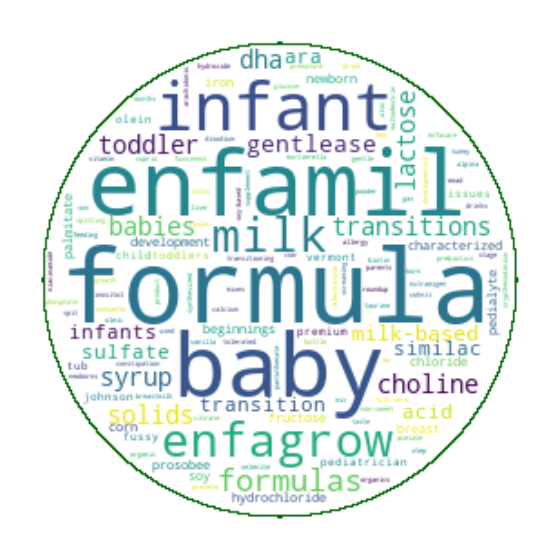

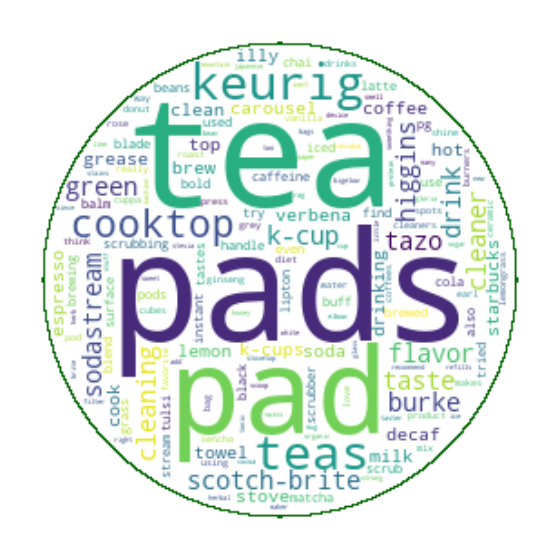

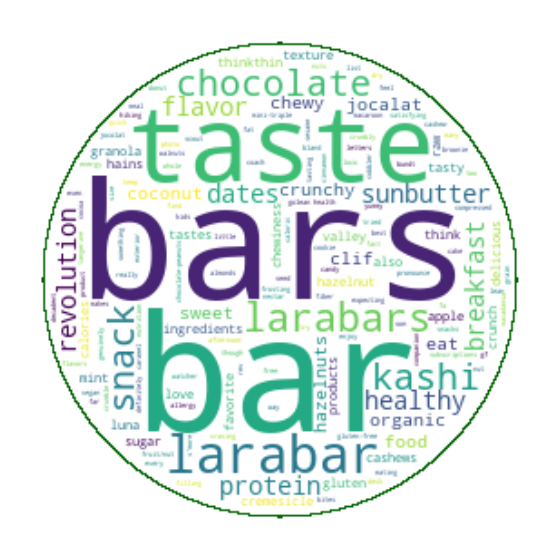

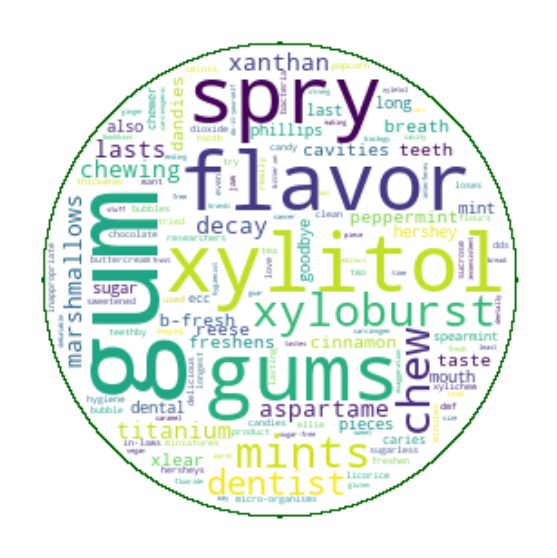

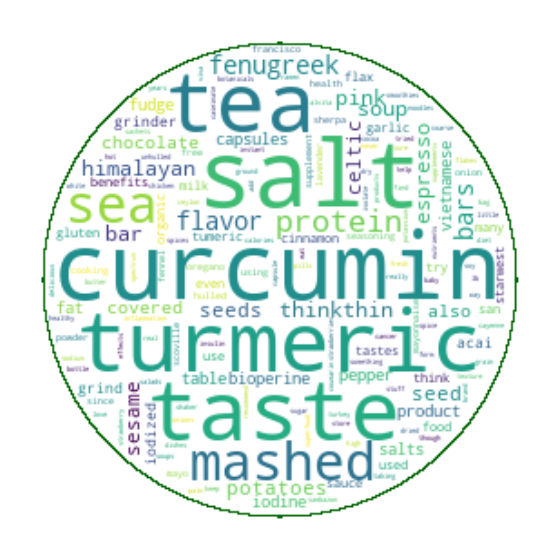

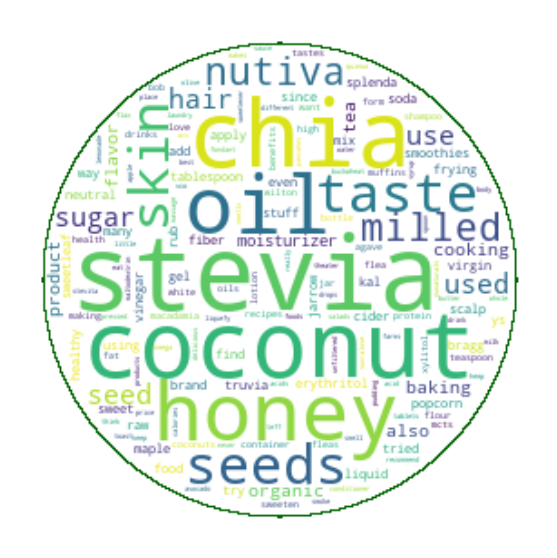

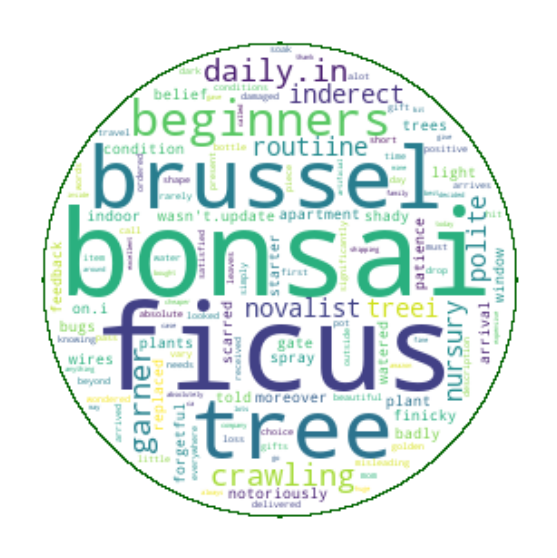

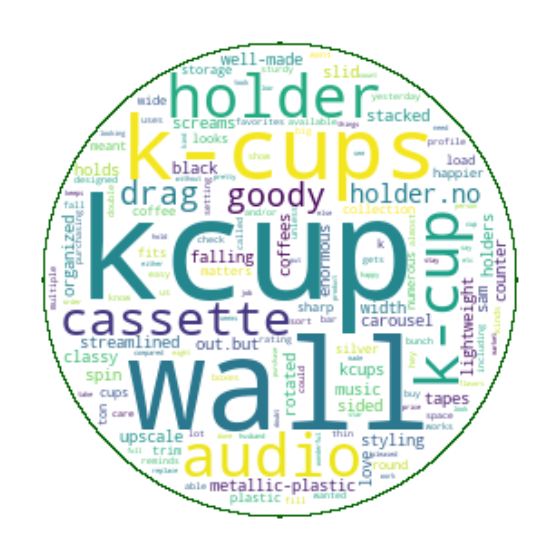

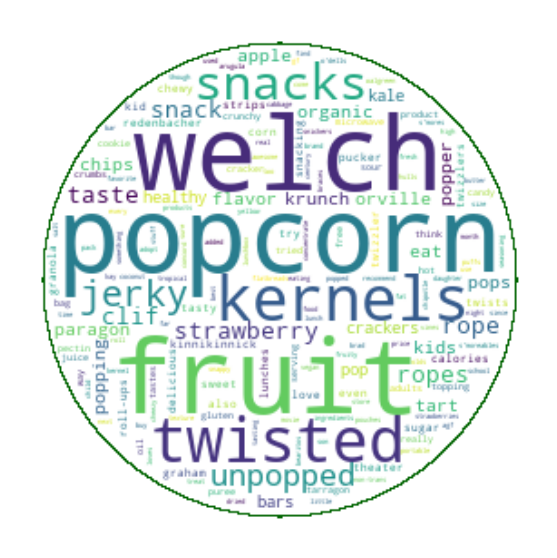

In [197]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)
wc = WordCloud(background_color="white", repeat=True, mask=mask)

for key in cat_dict.keys():
    unique_terms = np.unique(cat_dict[key])
    TF_IDF = {}
    a = dict(Counter(cat_dict[key],sorted=True))

    for t in unique_terms:
        if t in IDF_df.index:
            tf = a[t]/len(cat_dict[key])
            TF_IDF[t] = IDF_df['IDF'][t] * tf
    
    # make wordcloud from TF-IDF
    wordcloud = wc.generate_from_frequencies(TF_IDF)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [225]:
from os import path
from PIL import Image
import os

### Prøver med et billede fra Wordcloud, men kan ikke få det til at virke :((

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
plate_mask = np.array(Image.open(path.join(d, "data","wine.png")))

plate_mask = plate_mask[:,:,0]
plate_mask = plate_mask-255
plate_mask *= -1

UFuncTypeError: Cannot cast ufunc 'multiply' output from dtype('int16') to dtype('uint8') with casting rule 'same_kind'

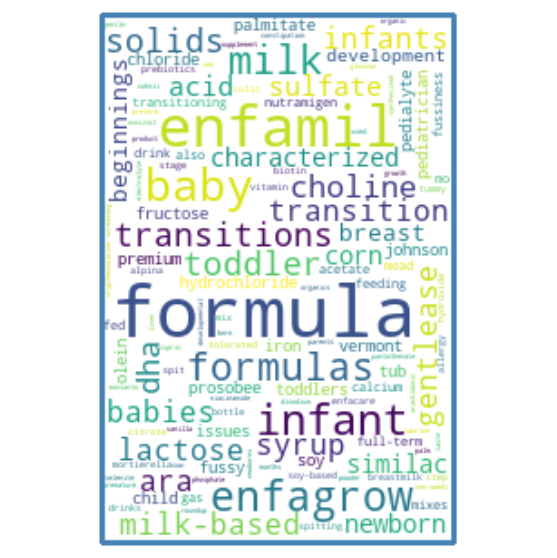

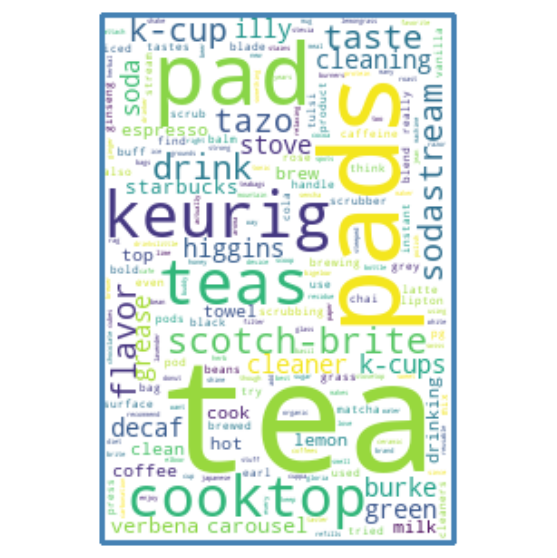

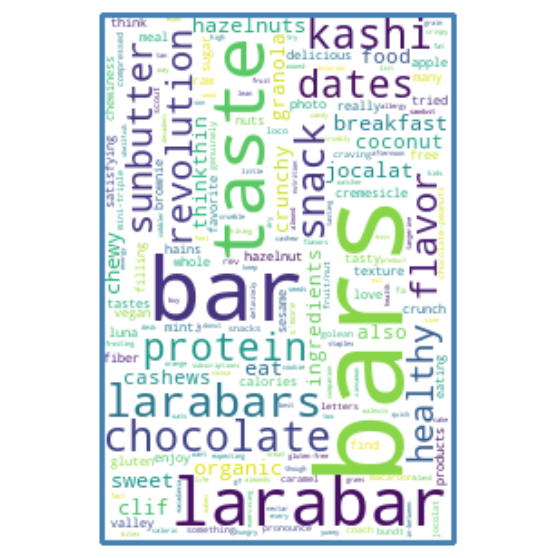

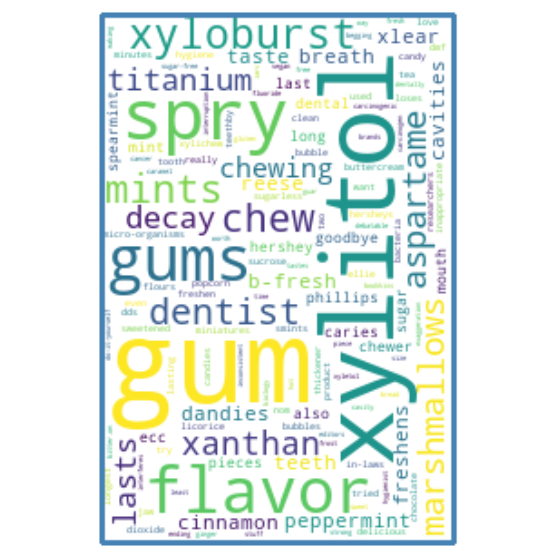

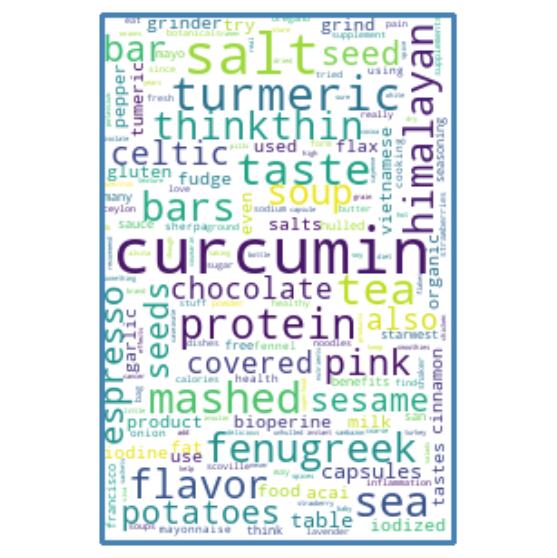

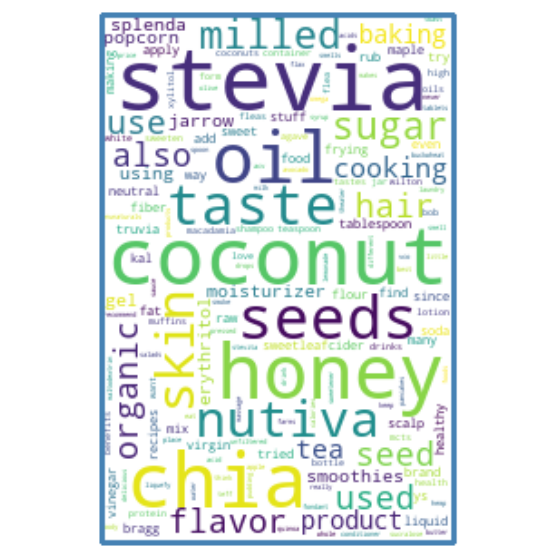

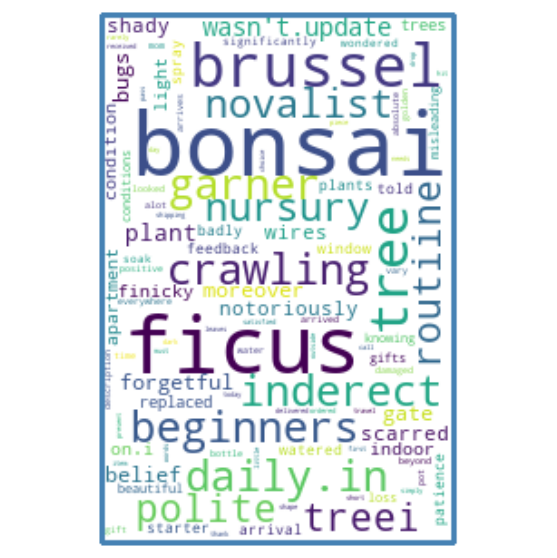

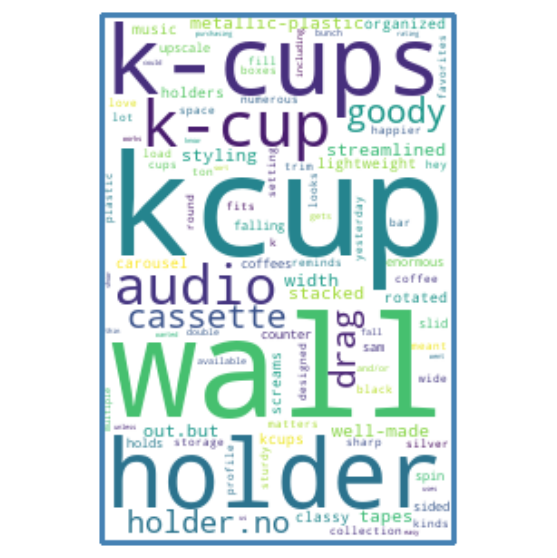

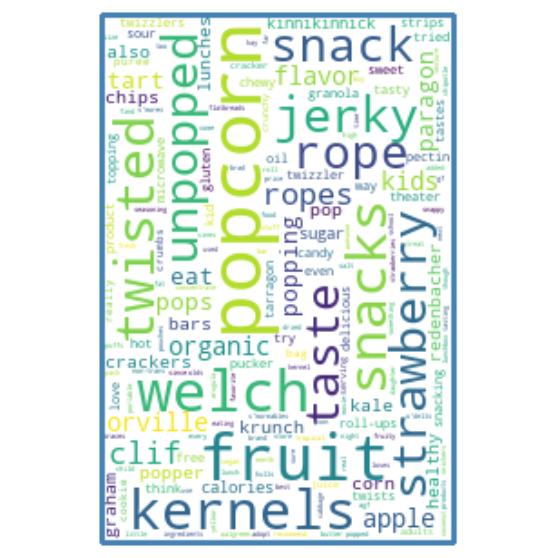

In [222]:
wc = WordCloud(background_color="white", mask=plate_mask, contour_width=1, contour_color='steelblue')


for key in cat_dict.keys():
    unique_terms = np.unique(cat_dict[key])
    TF_IDF = {}
    a = dict(Counter(cat_dict[key],sorted=True))

    for t in unique_terms:
        if t in IDF_df.index:
            tf = a[t]/len(cat_dict[key])
            TF_IDF[t] = IDF_df['IDF'][t] * tf
    
    # make wordcloud from TF-IDF
    wordcloud = wc.generate_from_frequencies(TF_IDF)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()